### Scenario- You are a junior data scientist on the Zillow data science team and are tasked with the following:

- Predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017
- Make recommendations to improve the current model
- Find the states and counties in which these properties are located


### Business goals:

- Create an ML Regression model that will predict property values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties
- Find the key drivers of property value for Single Family Properties. 
- Deliver a report that the data science team can read through and replicate. The team must be able to understand what steps were taken and why, and what the outcome was.
- Make recommendations on what works and what doesn't in predicting these property values.

In [1]:
#Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#my modules
import wrangle as wr
import evaluate as ev
import explore as exp
import prep
from env import get_db_url
from acquire import get_prop_vals

#sklearn imports
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

#extras
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)

### Acquiring data

In [5]:
# Show list of DBs in Codeup SQL server
wr.show_codeup_dbs()


List of Codeup DBs:



,Database
0,albums_db
1,chipotle
2,curriculum_logs
3,elo_db
4,employees
5,fruits_db
6,grocery_db
7,home_credit
8,information_schema
9,innis_1673


In [6]:
# Show tables in zillow DB
url = get_db_url('zillow')
pd.read_sql('SHOW TABLES', url)

,Tables_in_zillow
0,airconditioningtype
1,architecturalstyletype
2,buildingclasstype
3,heatingorsystemtype
4,predictions_2016
5,predictions_2017
6,properties_2016
7,properties_2017
8,propertylandusetype
9,storytype


In [7]:
#Show columns and data types in predictions_2017 table
pd.read_sql('DESCRIBE predictions_2017', url)

,Field,Type,Null,Key,Default,Extra
0,id,bigint,YES,MUL,None,
1,parcelid,bigint,YES,,None,
2,logerror,double,YES,,None,
3,transactiondate,text,YES,,None,


In [8]:
#Show columns and data types in propertylandusetype table
pd.read_sql('DESCRIBE propertylandusetype', url)

,Field,Type,Null,Key,Default,Extra
0,propertylandusetypeid,bigint,NO,PRI,None,
1,propertylandusedesc,text,YES,,None,


In [11]:
#Show columns and data types in properties_2017 table
pd.read_sql('DESCRIBE properties_2017', url)

,Field,Type,Null,Key,Default,Extra
0,id,bigint,YES,MUL,None,
1,parcelid,bigint,YES,MUL,None,
2,airconditioningtypeid,double,YES,,None,
3,architecturalstyletypeid,double,YES,,None,
4,basementsqft,double,YES,,None,
5,bathroomcnt,double,YES,,None,
6,bedroomcnt,double,YES,,None,
7,buildingclasstypeid,double,YES,,None,
8,buildingqualitytypeid,double,YES,,None,
9,calculatedbathnbr,double,YES,,None,


In [12]:
# Read in data dictionary for reference
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (if any)
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
2,'basementsqft',Finished living area below or partially below ground level
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the building from best (lowest) to worst (highest)
6,'buildingclasstypeid',"The building framing type (steel frame, wood frame, concrete/brick)"
7,'calculatedbathnbr',Number of bathrooms in home including fractional bathroom
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + sink + toilet)


In [13]:
# Acquire data using SQL query from acquire module
prop_vals = get_prop_vals()
prop_vals.info()
prop_vals.head()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    56071 non-null  float64
 1   bathroomcnt                   56071 non-null  float64
 2   roomcnt                       56071 non-null  float64
 3   numberofstories               15492 non-null  float64
 4   fireplaceflag                 68 non-null     float64
 5   poolcnt                       10951 non-null  float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  55846 non-null  float64
 8   lotsizesquarefeet             55723 non-null  float64
 9   structuretaxvaluedollarcnt    55875 non-null  float64
 10  landtaxvaluedollarcnt         56071 non-null  float64
 11  taxvaluedollarcnt             56071 non-null  float64
 12  yearbuilt                     55828

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4083.0,NaN,27516.0,27516.0,NaN,NaN,6037.0,0.055619
1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,11975.0,NaN,10.0,10.0,NaN,NaN,6037.0,0.008669
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,9403.0,NaN,10.0,10.0,NaN,NaN,6037.0,-0.021896
3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3817.0,NaN,2108.0,2108.0,NaN,174.21,6037.0,-0.017167
4,4.0,2.0,0.0,NaN,NaN,NaN,8.0,3633.0,9826.0,222321.0,74104.0,296425.0,2005.0,6941.39,6037.0,0.042463


In [14]:
# View summary stats
prop_vals.describe()

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,56071.000000,56071.000000,56071.000000,15492.000000,68.0,10951.0,36989.000000,55846.000000,5.572300e+04,5.587500e+04,5.607100e+04,5.607100e+04,55828.000000,5.594700e+04,56071.000000,56071.000000
mean,3.289490,2.239723,1.880295,1.384715,1.0,1.0,6.165860,1868.308617,1.155184e+04,1.799424e+05,2.783301e+05,4.576434e+05,1961.186466,5.589562e+03,6048.837991,0.016887
std,0.958204,1.006803,3.150662,0.532653,0.0,0.0,1.696977,966.979521,9.135534e+04,3.667285e+05,4.205952e+05,6.635581e+05,21.994730,8.541899e+03,21.232399,0.172747
min,0.000000,0.000000,0.000000,1.000000,1.0,1.0,1.000000,20.000000,1.670000e+02,5.000000e+00,4.000000e+00,9.000000e+00,1862.000000,8.300000e+00,6037.000000,-4.655420
25%,3.000000,2.000000,0.000000,1.000000,1.0,1.0,4.000000,1260.000000,5.687000e+03,7.512250e+04,7.789400e+04,1.870260e+05,1949.000000,2.524055e+03,6037.000000,-0.024377
50%,3.000000,2.000000,0.000000,1.000000,1.0,1.0,6.000000,1630.000000,6.803000e+03,1.237040e+05,1.826070e+05,3.295250e+05,1958.000000,4.130500e+03,6037.000000,0.006770
75%,4.000000,3.000000,5.000000,2.000000,1.0,1.0,8.000000,2217.000000,8.641000e+03,2.063965e+05,3.444580e+05,5.334845e+05,1976.000000,6.410755e+03,6059.000000,0.039526
max,25.000000,20.000000,86.000000,3.000000,1.0,1.0,12.000000,26345.000000,6.971010e+06,6.640493e+07,1.976448e+07,6.750649e+07,2016.000000,1.195296e+06,6111.000000,5.262999


In [15]:
# Getting null/NaN count
print(prop_vals.isnull().sum())
print('-----------------')
print(prop_vals.isna().sum())

bedroomcnt                          0
bathroomcnt                         0
roomcnt                             0
numberofstories                 40579
fireplaceflag                   56003
poolcnt                         45120
buildingqualitytypeid           19082
calculatedfinishedsquarefeet      225
lotsizesquarefeet                 348
structuretaxvaluedollarcnt        196
landtaxvaluedollarcnt               0
taxvaluedollarcnt                   0
yearbuilt                         243
taxamount                         124
fips                                0
logerror                            0
dtype: int64
-----------------
bedroomcnt                          0
bathroomcnt                         0
roomcnt                             0
numberofstories                 40579
fireplaceflag                   56003
poolcnt                         45120
buildingqualitytypeid           19082
calculatedfinishedsquarefeet      225
lotsizesquarefeet                 348
structuretaxvaluedo

In [16]:
# Which counties do we see in the data?
prop_vals.fips.value_counts()

6037.0    37283
6059.0    13972
6111.0     4816
Name: fips, dtype: int64

In [18]:
# Compared above output to FIPS county code list (https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county) to name subsets
orange_county = prop_vals[prop_vals.fips == 6059]
ventura_county = prop_vals[prop_vals.fips == 6111]
la_county = prop_vals[prop_vals.fips == 6037]

# Survey subsets
la_county.info()
la_county

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37283 entries, 0 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    37283 non-null  float64
 1   bathroomcnt                   37283 non-null  float64
 2   roomcnt                       37283 non-null  float64
 3   numberofstories               2 non-null      float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       7192 non-null   float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  37181 non-null  float64
 8   lotsizesquarefeet             37002 non-null  float64
 9   structuretaxvaluedollarcnt    37143 non-null  float64
 10  landtaxvaluedollarcnt         37283 non-null  float64
 11  taxvaluedollarcnt             37283 non-null  float64
 12  yearbuilt                     37178 non-null  float64
 13  t

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4083.0,NaN,27516.0,27516.0,NaN,NaN,6037.0,0.055619
1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,11975.0,NaN,10.0,10.0,NaN,NaN,6037.0,0.008669
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,9403.0,NaN,10.0,10.0,NaN,NaN,6037.0,-0.021896
3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3817.0,NaN,2108.0,2108.0,NaN,174.21,6037.0,-0.017167
4,4.0,2.0,0.0,NaN,NaN,NaN,8.0,3633.0,9826.0,222321.0,74104.0,296425.0,2005.0,6941.39,6037.0,0.042463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56066,2.0,2.0,0.0,NaN,NaN,NaN,8.0,1362.0,6854.0,101825.0,25451.0,127276.0,1996.0,2873.53,6037.0,0.001082
56067,3.0,2.0,0.0,NaN,NaN,NaN,8.0,1600.0,6709.0,137951.0,42764.0,180715.0,1992.0,3677.13,6037.0,-0.002245
56068,4.0,3.0,0.0,NaN,NaN,NaN,8.0,1921.0,6763.0,129566.0,32453.0,162019.0,1990.0,2860.33,6037.0,0.020615
56069,4.0,3.0,0.0,NaN,NaN,NaN,8.0,1780.0,6822.0,100744.0,25179.0,125923.0,1989.0,2394.26,6037.0,0.013209


In [19]:
# Get overview of Orange county subset
orange_county.info()
orange_county

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13972 entries, 23 to 53845
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    13972 non-null  float64
 1   bathroomcnt                   13972 non-null  float64
 2   roomcnt                       13972 non-null  float64
 3   numberofstories               10734 non-null  float64
 4   fireplaceflag                 68 non-null     float64
 5   poolcnt                       2956 non-null   float64
 6   buildingqualitytypeid         0 non-null      float64
 7   calculatedfinishedsquarefeet  13908 non-null  float64
 8   lotsizesquarefeet             13906 non-null  float64
 9   structuretaxvaluedollarcnt    13965 non-null  float64
 10  landtaxvaluedollarcnt         13972 non-null  float64
 11  taxvaluedollarcnt             13972 non-null  float64
 12  yearbuilt                     13915 non-null  float64
 13  

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
23,3.0,2.5,0.0,NaN,NaN,NaN,NaN,1821.0,2442.0,265668.0,272281.0,537949.0,2013.0,6173.72,6059.0,0.344151
24,4.0,3.5,0.0,NaN,NaN,NaN,NaN,2684.0,3510.0,395167.0,249823.0,644990.0,2014.0,7572.58,6059.0,-0.133486
25,3.0,2.5,0.0,NaN,NaN,NaN,NaN,2284.0,3398.0,478915.0,455438.0,934353.0,2014.0,13273.94,6059.0,-0.012117
26,3.0,3.0,0.0,NaN,NaN,NaN,NaN,2342.0,3508.0,401678.0,768462.0,1170140.0,2014.0,12861.66,6059.0,-0.052570
27,4.0,3.0,0.0,NaN,NaN,NaN,NaN,2666.0,5145.0,494837.0,431611.0,926448.0,2015.0,15751.54,6059.0,0.008924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53834,3.0,2.0,7.0,1.0,NaN,NaN,NaN,1797.0,10148.0,190012.0,178841.0,368853.0,1964.0,4507.88,6059.0,-0.106412
53835,4.0,2.5,8.0,1.0,NaN,NaN,NaN,3009.0,29000.0,222136.0,627864.0,850000.0,1975.0,9669.94,6059.0,0.474770
53843,5.0,4.5,0.0,NaN,NaN,NaN,NaN,3207.0,6006.0,591464.0,308536.0,900000.0,2015.0,10059.28,6059.0,0.032276
53844,4.0,3.0,0.0,NaN,NaN,NaN,NaN,2318.0,2881.0,350317.0,417730.0,768047.0,2015.0,9176.62,6059.0,0.003474


In [16]:
#Get overview of Ventura county subset
ventura_county.info()
ventura_county

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4816 entries, 36 to 54581
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    4816 non-null   float64
 1   bathroomcnt                   4816 non-null   float64
 2   roomcnt                       4816 non-null   float64
 3   numberofstories               4756 non-null   float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       803 non-null    float64
 6   buildingqualitytypeid         0 non-null      float64
 7   calculatedfinishedsquarefeet  4757 non-null   float64
 8   lotsizesquarefeet             4815 non-null   float64
 9   structuretaxvaluedollarcnt    4767 non-null   float64
 10  landtaxvaluedollarcnt         4816 non-null   float64
 11  taxvaluedollarcnt             4816 non-null   float64
 12  yearbuilt                     4735 non-null   float64
 13  t

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
36,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,892352.0,348503.0,223577.0,572080.0,NaN,6142.48,6111.0,0.042956
37,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2255.0,NaN,75001.0,75001.0,NaN,854.48,6111.0,0.056048
38,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3750.0,NaN,28370.0,28370.0,NaN,350.26,6111.0,-0.254507
52,4.0,4.0,8.0,1.0,NaN,1.0,NaN,4969.0,120226.0,779712.0,1448761.0,2228473.0,1989.0,24556.86,6111.0,0.006783
53,3.0,2.0,0.0,2.0,NaN,NaN,NaN,1800.0,19323.0,319803.0,475137.0,794940.0,1932.0,8571.20,6111.0,0.054386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54577,3.0,2.5,7.0,2.0,NaN,NaN,NaN,2213.0,5285.0,321667.0,321667.0,643334.0,1989.0,8228.76,6111.0,0.012300
54578,4.0,3.0,7.0,2.0,NaN,NaN,NaN,1628.0,5143.0,273059.0,273059.0,546118.0,1985.0,7032.56,6111.0,0.135708
54579,5.0,4.5,10.0,2.0,NaN,1.0,NaN,3644.0,7565.0,597535.0,398352.0,995887.0,1999.0,12197.70,6111.0,0.391259
54580,6.0,6.5,13.0,2.0,NaN,1.0,NaN,7454.0,49222.0,1052448.0,542124.0,1594572.0,1992.0,18096.22,6111.0,0.015434


In [17]:
# View LA county summary stats
la_county.describe()

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,37283.000000,37283.000000,37283.0,2.0,0.0,7192.0,36989.000000,37181.000000,3.700200e+04,3.714300e+04,3.728300e+04,3.728300e+04,37178.000000,37170.000000,37283.0,37283.000000
mean,3.188585,2.150256,0.0,1.0,NaN,1.0,6.165860,1779.976574,1.275239e+04,1.706667e+05,2.619570e+05,4.319829e+05,1955.588574,5450.635183,6037.0,0.016884
std,0.965433,1.047044,0.0,0.0,NaN,0.0,1.696977,953.802946,1.106807e+05,2.421178e+05,4.232252e+05,6.150391e+05,21.618597,7249.236956,0.0,0.171929
min,0.000000,0.000000,0.0,1.0,NaN,1.0,1.000000,20.000000,1.690000e+02,5.000000e+00,4.000000e+00,9.000000e+00,1862.000000,13.490000,6037.0,-4.655420
25%,3.000000,1.000000,0.0,1.0,NaN,1.0,4.000000,1200.000000,5.708250e+03,7.186550e+04,6.521500e+04,1.694610e+05,1945.000000,2397.325000,6037.0,-0.024159
50%,3.000000,2.000000,0.0,1.0,NaN,1.0,6.000000,1540.000000,6.835000e+03,1.171380e+05,1.639400e+05,2.970880e+05,1953.000000,3911.810000,6037.0,0.006860
75%,4.000000,3.000000,0.0,1.0,NaN,1.0,8.000000,2080.000000,8.820000e+03,1.905505e+05,3.121310e+05,4.870000e+05,1965.000000,6100.700000,6037.0,0.039364
max,25.000000,20.000000,0.0,1.0,NaN,1.0,12.000000,19335.000000,6.971010e+06,1.087622e+07,1.976448e+07,3.016684e+07,2016.000000,342940.380000,6037.0,3.394544


In [18]:
# View Orange county summary stats
orange_county.describe()

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,13972.000000,13972.000000,13972.000000,10734.000000,68.0,2956.0,0.0,13908.000000,13906.000000,1.396500e+04,1.397200e+04,1.397200e+04,13915.000000,1.396200e+04,13972.0,13972.000000
mean,3.480962,2.444926,5.194317,1.385225,1.0,1.0,NaN,2057.907607,7581.419747,1.926234e+05,3.430392e+05,5.355661e+05,1971.999425,6.197379e+03,6059.0,0.016579
std,0.906001,0.898402,3.149229,0.547739,0.0,0.0,NaN,976.048181,9108.626153,6.090449e+05,4.561861e+05,8.396346e+05,18.237036,1.210282e+04,0.0,0.171261
min,0.000000,0.000000,0.000000,1.000000,1.0,1.0,NaN,368.000000,167.000000,8.150000e+02,2.200000e+02,1.035000e+03,1896.000000,2.024000e+01,6059.0,-2.387800
25%,3.000000,2.000000,4.000000,1.000000,1.0,1.0,NaN,1422.000000,5240.250000,7.506400e+04,1.242935e+05,2.427362e+05,1959.000000,2.903790e+03,6059.0,-0.025289
50%,3.000000,2.500000,6.000000,1.000000,1.0,1.0,NaN,1848.000000,6500.500000,1.214940e+05,2.579910e+05,4.082535e+05,1970.000000,4.697280e+03,6059.0,0.006130
75%,4.000000,3.000000,7.000000,2.000000,1.0,1.0,NaN,2460.000000,7937.500000,2.217230e+05,4.375628e+05,6.371578e+05,1985.000000,7.186490e+03,6059.0,0.039649
max,10.000000,19.500000,86.000000,3.000000,1.0,1.0,NaN,26345.000000,628897.000000,6.640493e+07,1.191070e+07,6.750649e+07,2015.000000,1.195296e+06,6059.0,3.084717


In [19]:
#View ventura county summary stats
ventura_county.describe()

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,4816.000000,4816.000000,4816.000000,4756.000000,0.0,803.0,0.0,4757.000000,4.815000e+03,4.767000e+03,4.816000e+03,4.816000e+03,4735.000000,4815.000000,4816.0,4816.000000
mean,3.515158,2.337002,6.822051,1.383726,NaN,1.0,NaN,2004.388270,1.379271e+04,2.150661e+05,2.173500e+05,4.302278e+05,1973.363041,4899.541919,6111.0,0.017801
std,0.925792,0.883040,1.773961,0.497037,NaN,0.0,NaN,947.170404,4.630968e+04,1.750927e+05,2.264948e+05,3.597033e+05,17.862504,3963.083520,0.0,0.183076
min,0.000000,0.000000,0.000000,1.000000,NaN,1.0,NaN,272.000000,1.057000e+03,1.140000e+03,4.040000e+02,4.040000e+02,1890.000000,8.300000,6111.0,-2.241126
25%,3.000000,2.000000,6.000000,1.000000,NaN,1.0,NaN,1412.000000,6.119500e+03,1.280200e+05,8.769250e+04,2.306538e+05,1962.000000,2666.810000,6111.0,-0.023784
50%,4.000000,2.000000,7.000000,1.000000,NaN,1.0,NaN,1807.000000,7.312000e+03,1.857080e+05,1.638815e+05,3.728285e+05,1972.000000,4282.400000,6111.0,0.007535
75%,4.000000,3.000000,8.000000,2.000000,NaN,1.0,NaN,2361.000000,1.000300e+04,2.637490e+05,2.884892e+05,5.350742e+05,1986.000000,6049.590000,6111.0,0.040852
max,8.000000,9.500000,22.000000,3.000000,NaN,1.0,NaN,20433.000000,1.743045e+06,4.271638e+06,3.727000e+06,7.307000e+06,2016.000000,77266.840000,6111.0,5.262999


In [20]:
print(f'LA county avg SFR tax assessed value: ${la_county.taxvaluedollarcnt.mean():.2f}')
print(f'Orange county avg SFR tax assessed value: ${orange_county.taxvaluedollarcnt.mean():.2f}')
print(f'Ventura county avg SFR tax assessed value: ${ventura_county.taxvaluedollarcnt.mean():.2f}')

LA county avg SFR tax assessed value: $431982.91
Orange county avg SFR tax assessed value: $535566.11
Ventura county avg SFR tax assessed value: $430227.85


### Takeaways: Noted differences in data collection between counties -- data for the variable 'buildingqualitytypeid' was exclusively collected in LA county, while 'fireplaceflag' was only collected in Orange county. For analysis and modeling, consider dividing the dataset by county. Analyze and run models for each.

6.0     11973
4.0      9436
8.0      8633
7.0      3181
5.0      1733
9.0      1015
11.0      487
10.0      238
3.0       187
12.0       86
1.0        14
2.0         6
Name: buildingqualitytypeid, dtype: int64


<AxesSubplot:ylabel='Frequency'>

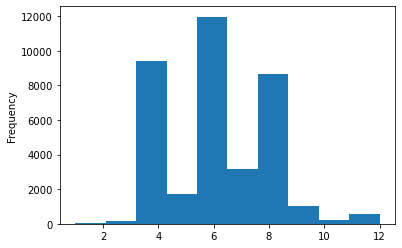

In [21]:
rated_bldgs = prop_vals[prop_vals.buildingqualitytypeid.notna()]

print(rated_bldgs.buildingqualitytypeid.value_counts())

rated_bldgs.buildingqualitytypeid.plot.hist()



### Sort of normal, sort of three-headed distribution for the ratings of buildings with quality ratings. Do some means testing (t-tests) on this subset, if there's time.

In [22]:
rated_bldgs.describe()

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,36989.000000,36989.000000,36989.0,2.0,0.0,7149.0,36989.000000,36985.000000,3.674200e+04,3.693500e+04,3.698900e+04,3.698900e+04,36982.000000,36926.000000,36989.0,36989.000000
mean,3.202871,2.155100,0.0,1.0,NaN,1.0,6.165860,1774.980938,1.234485e+04,1.673420e+05,2.576443e+05,4.247420e+05,1955.540750,5357.045657,6037.0,0.016848
std,0.936442,1.024481,0.0,0.0,NaN,0.0,1.696977,927.338037,1.083834e+05,2.037831e+05,3.783027e+05,5.363399e+05,21.550074,6302.209573,0.0,0.171279
min,0.000000,0.000000,0.0,1.0,NaN,1.0,1.000000,320.000000,5.000000e+02,1.000000e+01,2.250000e+03,7.584000e+03,1862.000000,108.930000,6037.0,-4.655420
25%,3.000000,1.000000,0.0,1.0,NaN,1.0,4.000000,1200.000000,5.711000e+03,7.205850e+04,6.567200e+04,1.706050e+05,1946.000000,2403.925000,6037.0,-0.024179
50%,3.000000,2.000000,0.0,1.0,NaN,1.0,6.000000,1540.000000,6.830500e+03,1.172120e+05,1.642340e+05,2.976190e+05,1953.000000,3912.820000,6037.0,0.006860
75%,4.000000,3.000000,0.0,1.0,NaN,1.0,8.000000,2078.000000,8.793500e+03,1.902160e+05,3.120260e+05,4.867180e+05,1965.000000,6093.360000,6037.0,0.039375
max,25.000000,20.000000,0.0,1.0,NaN,1.0,12.000000,19335.000000,6.971010e+06,4.732194e+06,1.421350e+07,1.878212e+07,2016.000000,224696.170000,6037.0,3.394544


In [23]:
rated_bldgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36989 entries, 4 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    36989 non-null  float64
 1   bathroomcnt                   36989 non-null  float64
 2   roomcnt                       36989 non-null  float64
 3   numberofstories               2 non-null      float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       7149 non-null   float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  36985 non-null  float64
 8   lotsizesquarefeet             36742 non-null  float64
 9   structuretaxvaluedollarcnt    36935 non-null  float64
 10  landtaxvaluedollarcnt         36989 non-null  float64
 11  taxvaluedollarcnt             36989 non-null  float64
 12  yearbuilt                     36982 non-null  float64
 13  t

<AxesSubplot:ylabel='Frequency'>

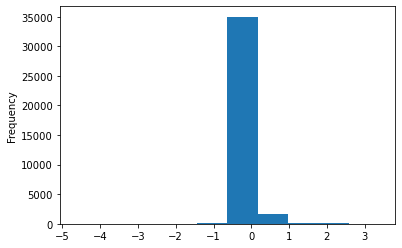

In [24]:
rated_bldgs.logerror.plot.hist()

In [25]:
rated_bldgs.fips.value_counts()

6037.0    36989
Name: fips, dtype: int64

In [26]:
print(f'Avg tax assessed value for properties rated above 6: ${rated_bldgs[rated_bldgs.buildingqualitytypeid <= 6].taxvaluedollarcnt.mean():.2f}')
print(f'Avg tax assessed value for properties rated below 6: ${rated_bldgs[rated_bldgs.buildingqualitytypeid > 6].taxvaluedollarcnt.mean():.2f}')
print(f'Number of properties below 6 in condition: {len(rated_bldgs[rated_bldgs.buildingqualitytypeid > 6])}')
print(f'Number of properties 6 or above in condition: {len(rated_bldgs[rated_bldgs.buildingqualitytypeid <= 6])}')

Avg tax assessed value for properties rated above 6: $280204.19
Avg tax assessed value for properties rated below 6: $672162.38
Number of properties below 6 in condition: 13640
Number of properties 6 or above in condition: 23349


Strange numbers here. Lower "buildingqualitytypeid' numbers are supposed to mean better condition, which logically, would mean higher value, but these numbers defy that logic.

In [27]:
rated_bldgs.buildingqualitytypeid.value_counts()

6.0     11973
4.0      9436
8.0      8633
7.0      3181
5.0      1733
9.0      1015
11.0      487
10.0      238
3.0       187
12.0       86
1.0        14
2.0         6
Name: buildingqualitytypeid, dtype: int64

### Cleaning

In [28]:
la_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37283 entries, 0 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    37283 non-null  float64
 1   bathroomcnt                   37283 non-null  float64
 2   roomcnt                       37283 non-null  float64
 3   numberofstories               2 non-null      float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       7192 non-null   float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  37181 non-null  float64
 8   lotsizesquarefeet             37002 non-null  float64
 9   structuretaxvaluedollarcnt    37143 non-null  float64
 10  landtaxvaluedollarcnt         37283 non-null  float64
 11  taxvaluedollarcnt             37283 non-null  float64
 12  yearbuilt                     37178 non-null  float64
 13  t

In [29]:
la_county.describe()

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,37283.000000,37283.000000,37283.0,2.0,0.0,7192.0,36989.000000,37181.000000,3.700200e+04,3.714300e+04,3.728300e+04,3.728300e+04,37178.000000,37170.000000,37283.0,37283.000000
mean,3.188585,2.150256,0.0,1.0,NaN,1.0,6.165860,1779.976574,1.275239e+04,1.706667e+05,2.619570e+05,4.319829e+05,1955.588574,5450.635183,6037.0,0.016884
std,0.965433,1.047044,0.0,0.0,NaN,0.0,1.696977,953.802946,1.106807e+05,2.421178e+05,4.232252e+05,6.150391e+05,21.618597,7249.236956,0.0,0.171929
min,0.000000,0.000000,0.0,1.0,NaN,1.0,1.000000,20.000000,1.690000e+02,5.000000e+00,4.000000e+00,9.000000e+00,1862.000000,13.490000,6037.0,-4.655420
25%,3.000000,1.000000,0.0,1.0,NaN,1.0,4.000000,1200.000000,5.708250e+03,7.186550e+04,6.521500e+04,1.694610e+05,1945.000000,2397.325000,6037.0,-0.024159
50%,3.000000,2.000000,0.0,1.0,NaN,1.0,6.000000,1540.000000,6.835000e+03,1.171380e+05,1.639400e+05,2.970880e+05,1953.000000,3911.810000,6037.0,0.006860
75%,4.000000,3.000000,0.0,1.0,NaN,1.0,8.000000,2080.000000,8.820000e+03,1.905505e+05,3.121310e+05,4.870000e+05,1965.000000,6100.700000,6037.0,0.039364
max,25.000000,20.000000,0.0,1.0,NaN,1.0,12.000000,19335.000000,6.971010e+06,1.087622e+07,1.976448e+07,3.016684e+07,2016.000000,342940.380000,6037.0,3.394544


In [30]:
la_county.isnull().sum() / len(la_county)

bedroomcnt                      0.000000
bathroomcnt                     0.000000
roomcnt                         0.000000
numberofstories                 0.999946
fireplaceflag                   1.000000
poolcnt                         0.807097
buildingqualitytypeid           0.007886
calculatedfinishedsquarefeet    0.002736
lotsizesquarefeet               0.007537
structuretaxvaluedollarcnt      0.003755
landtaxvaluedollarcnt           0.000000
taxvaluedollarcnt               0.000000
yearbuilt                       0.002816
taxamount                       0.003031
fips                            0.000000
logerror                        0.000000
dtype: float64

In [31]:
la_county = la_county.drop(columns= ['roomcnt', 'numberofstories', 'fireplaceflag'])


In [32]:
la_county.poolcnt = la_county.poolcnt.fillna(0)
la_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37283 entries, 0 to 56070
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    37283 non-null  float64
 1   bathroomcnt                   37283 non-null  float64
 2   poolcnt                       37283 non-null  float64
 3   buildingqualitytypeid         36989 non-null  float64
 4   calculatedfinishedsquarefeet  37181 non-null  float64
 5   lotsizesquarefeet             37002 non-null  float64
 6   structuretaxvaluedollarcnt    37143 non-null  float64
 7   landtaxvaluedollarcnt         37283 non-null  float64
 8   taxvaluedollarcnt             37283 non-null  float64
 9   yearbuilt                     37178 non-null  float64
 10  taxamount                     37170 non-null  float64
 11  fips                          37283 non-null  float64
 12  logerror                      37283 non-null  float64
dtypes

In [33]:
la_county_clean = la_county.dropna()
la_county_clean.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 36675 entries, 4 to 56070
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    36675 non-null  float64
 1   bathroomcnt                   36675 non-null  float64
 2   poolcnt                       36675 non-null  float64
 3   buildingqualitytypeid         36675 non-null  float64
 4   calculatedfinishedsquarefeet  36675 non-null  float64
 5   lotsizesquarefeet             36675 non-null  float64
 6   structuretaxvaluedollarcnt    36675 non-null  float64
 7   landtaxvaluedollarcnt         36675 non-null  float64
 8   taxvaluedollarcnt             36675 non-null  float64
 9   yearbuilt                     36675 non-null  float64
 10  taxamount                     36675 non-null  float64
 11  fips                          36675 non-null  float64
 12  logerror                      36675 non-null  float64
dtypes

In [34]:
# Convert data types as appropriate (rooms, building quality, year built = 'int64', pool count = 'uint8' )
la_county_clean.bedroomcnt = la_county_clean.bedroomcnt.astype('int64')
la_county_clean.bathroomcnt = la_county_clean.bathroomcnt.astype('int64')
la_county_clean.buildingqualitytypeid = la_county_clean.buildingqualitytypeid.astype('int64')
la_county_clean.poolcnt = la_county_clean.poolcnt.astype('uint8')
la_county_clean.yearbuilt = la_county_clean.yearbuilt.astype('int64')
la_county_clean.fips = la_county_clean.fips.astype('int64')

la_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36675 entries, 4 to 56070
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    36675 non-null  int64  
 1   bathroomcnt                   36675 non-null  int64  
 2   poolcnt                       36675 non-null  uint8  
 3   buildingqualitytypeid         36675 non-null  int64  
 4   calculatedfinishedsquarefeet  36675 non-null  float64
 5   lotsizesquarefeet             36675 non-null  float64
 6   structuretaxvaluedollarcnt    36675 non-null  float64
 7   landtaxvaluedollarcnt         36675 non-null  float64
 8   taxvaluedollarcnt             36675 non-null  float64
 9   yearbuilt                     36675 non-null  int64  
 10  taxamount                     36675 non-null  float64
 11  fips                          36675 non-null  int64  
 12  logerror                      36675 non-null  float64
dtypes

In [35]:
la_county_clean = la_county_clean.rename(columns = {
    'bedroomcnt': 'beds', 
    'bathroomcnt': 'baths', 
    'poolcnt': 'pool', 
    'buildingqualitytypeid': 'condition', 
    'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
    'lotsizesquarefeet': 'lot_sqft', 
    'structuretaxvaluedollarcnt': 'structure_tax_val',
    'landtaxvaluedollarcnt': 'land_tax_val',
    'taxvaluedollarcnt': 'tax_val', 
    'yearbuilt': 'yr_built', 
    'taxamount': 'tax_amt', 
    'fips': 'county_code', 
    'logerror': 'log_err' 
    })

In [36]:
la_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36675 entries, 4 to 56070
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beds               36675 non-null  int64  
 1   baths              36675 non-null  int64  
 2   pool               36675 non-null  uint8  
 3   condition          36675 non-null  int64  
 4   calc_fin_sqft      36675 non-null  float64
 5   lot_sqft           36675 non-null  float64
 6   structure_tax_val  36675 non-null  float64
 7   land_tax_val       36675 non-null  float64
 8   tax_val            36675 non-null  float64
 9   yr_built           36675 non-null  int64  
 10  tax_amt            36675 non-null  float64
 11  county_code        36675 non-null  int64  
 12  log_err            36675 non-null  float64
dtypes: float64(7), int64(5), uint8(1)
memory usage: 3.7 MB


In [37]:
orange_county.info()
orange_county.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13972 entries, 23 to 53845
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    13972 non-null  float64
 1   bathroomcnt                   13972 non-null  float64
 2   roomcnt                       13972 non-null  float64
 3   numberofstories               10734 non-null  float64
 4   fireplaceflag                 68 non-null     float64
 5   poolcnt                       2956 non-null   float64
 6   buildingqualitytypeid         0 non-null      float64
 7   calculatedfinishedsquarefeet  13908 non-null  float64
 8   lotsizesquarefeet             13906 non-null  float64
 9   structuretaxvaluedollarcnt    13965 non-null  float64
 10  landtaxvaluedollarcnt         13972 non-null  float64
 11  taxvaluedollarcnt             13972 non-null  float64
 12  yearbuilt                     13915 non-null  float64
 13  

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,13972.000000,13972.000000,13972.000000,10734.000000,68.0,2956.0,0.0,13908.000000,13906.000000,1.396500e+04,1.397200e+04,1.397200e+04,13915.000000,1.396200e+04,13972.0,13972.000000
mean,3.480962,2.444926,5.194317,1.385225,1.0,1.0,NaN,2057.907607,7581.419747,1.926234e+05,3.430392e+05,5.355661e+05,1971.999425,6.197379e+03,6059.0,0.016579
std,0.906001,0.898402,3.149229,0.547739,0.0,0.0,NaN,976.048181,9108.626153,6.090449e+05,4.561861e+05,8.396346e+05,18.237036,1.210282e+04,0.0,0.171261
min,0.000000,0.000000,0.000000,1.000000,1.0,1.0,NaN,368.000000,167.000000,8.150000e+02,2.200000e+02,1.035000e+03,1896.000000,2.024000e+01,6059.0,-2.387800
25%,3.000000,2.000000,4.000000,1.000000,1.0,1.0,NaN,1422.000000,5240.250000,7.506400e+04,1.242935e+05,2.427362e+05,1959.000000,2.903790e+03,6059.0,-0.025289
50%,3.000000,2.500000,6.000000,1.000000,1.0,1.0,NaN,1848.000000,6500.500000,1.214940e+05,2.579910e+05,4.082535e+05,1970.000000,4.697280e+03,6059.0,0.006130
75%,4.000000,3.000000,7.000000,2.000000,1.0,1.0,NaN,2460.000000,7937.500000,2.217230e+05,4.375628e+05,6.371578e+05,1985.000000,7.186490e+03,6059.0,0.039649
max,10.000000,19.500000,86.000000,3.000000,1.0,1.0,NaN,26345.000000,628897.000000,6.640493e+07,1.191070e+07,6.750649e+07,2015.000000,1.195296e+06,6059.0,3.084717


In [38]:
orange_county = orange_county.drop(columns= ['buildingqualitytypeid'])
orange_county.fireplaceflag = orange_county.fireplaceflag.fillna(0)
orange_county.poolcnt = orange_county.poolcnt.fillna(0)
orange_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13972 entries, 23 to 53845
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    13972 non-null  float64
 1   bathroomcnt                   13972 non-null  float64
 2   roomcnt                       13972 non-null  float64
 3   numberofstories               10734 non-null  float64
 4   fireplaceflag                 13972 non-null  float64
 5   poolcnt                       13972 non-null  float64
 6   calculatedfinishedsquarefeet  13908 non-null  float64
 7   lotsizesquarefeet             13906 non-null  float64
 8   structuretaxvaluedollarcnt    13965 non-null  float64
 9   landtaxvaluedollarcnt         13972 non-null  float64
 10  taxvaluedollarcnt             13972 non-null  float64
 11  yearbuilt                     13915 non-null  float64
 12  taxamount                     13962 non-null  float64
 13  

In [39]:
orange_county_clean = orange_county.dropna()

orange_county_clean.info()
orange_county_clean.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 7631 to 53835
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    10695 non-null  float64
 1   bathroomcnt                   10695 non-null  float64
 2   roomcnt                       10695 non-null  float64
 3   numberofstories               10695 non-null  float64
 4   fireplaceflag                 10695 non-null  float64
 5   poolcnt                       10695 non-null  float64
 6   calculatedfinishedsquarefeet  10695 non-null  float64
 7   lotsizesquarefeet             10695 non-null  float64
 8   structuretaxvaluedollarcnt    10695 non-null  float64
 9   landtaxvaluedollarcnt         10695 non-null  float64
 10  taxvaluedollarcnt             10695 non-null  float64
 11  yearbuilt                     10695 non-null  float64
 12  taxamount                     10695 non-null  float64
 13

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,1.069500e+04,1.069500e+04,1.069500e+04,10695.000000,10695.000000,10695.0,10695.000000
mean,3.433193,2.248340,6.725853,1.385694,0.005797,0.218607,1849.292473,7400.707807,1.277407e+05,3.017324e+05,4.294731e+05,1965.208322,4908.691802,6059.0,0.017767
std,0.859278,0.712174,1.600104,0.547877,0.075921,0.413321,727.887823,5330.964755,1.258585e+05,4.072617e+05,4.852988e+05,13.739841,5084.008734,0.0,0.177912
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,368.000000,540.000000,5.864000e+03,2.707000e+03,1.254500e+04,1896.000000,20.240000,6059.0,-2.387800
25%,3.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1347.000000,5900.000000,6.699150e+04,1.013220e+05,2.062640e+05,1957.000000,2523.240000,6059.0,-0.024954
50%,3.000000,2.000000,7.000000,1.000000,0.000000,0.000000,1688.000000,6700.000000,9.860500e+04,2.245820e+05,3.465970e+05,1965.000000,4056.880000,6059.0,0.006307
75%,4.000000,2.500000,8.000000,2.000000,0.000000,0.000000,2200.000000,7920.000000,1.508705e+05,3.980335e+05,5.265265e+05,1973.000000,5979.930000,6059.0,0.039726
max,8.000000,9.000000,86.000000,3.000000,1.000000,1.000000,13659.000000,178596.000000,4.397016e+06,9.961301e+06,1.151792e+07,2015.000000,121161.260000,6059.0,3.084717


In [40]:
orange_county_clean.numberofstories.sort_values()
orange_county_clean.numberofstories.isna().sum()


0

In [41]:
orange_county_clean.bedroomcnt = orange_county_clean.bedroomcnt.astype('int64')
orange_county_clean.bathroomcnt = orange_county_clean.bathroomcnt.astype('int64')
orange_county_clean.roomcnt = orange_county_clean.roomcnt.astype('int64')
orange_county_clean.numberofstories = orange_county_clean.numberofstories.astype('int64')
orange_county_clean.fireplaceflag = orange_county_clean.fireplaceflag.astype('uint8')
orange_county_clean.poolcnt = orange_county_clean.poolcnt.astype('uint8')
orange_county_clean.yearbuilt = orange_county_clean.yearbuilt.astype('int64')
orange_county_clean.fips = orange_county_clean.fips.astype('int64')

orange_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 7631 to 53835
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    10695 non-null  int64  
 1   bathroomcnt                   10695 non-null  int64  
 2   roomcnt                       10695 non-null  int64  
 3   numberofstories               10695 non-null  int64  
 4   fireplaceflag                 10695 non-null  uint8  
 5   poolcnt                       10695 non-null  uint8  
 6   calculatedfinishedsquarefeet  10695 non-null  float64
 7   lotsizesquarefeet             10695 non-null  float64
 8   structuretaxvaluedollarcnt    10695 non-null  float64
 9   landtaxvaluedollarcnt         10695 non-null  float64
 10  taxvaluedollarcnt             10695 non-null  float64
 11  yearbuilt                     10695 non-null  int64  
 12  taxamount                     10695 non-null  float64
 13

In [42]:
orange_county_clean = orange_county_clean.rename(columns= {
    'bedroomcnt': 'beds', 
    'bathroomcnt': 'baths', 
    'roomcnt': 'total_rooms',
    'numberofstories': 'stories',
    'fireplaceflag': 'fireplace',
    'poolcnt': 'pools',  
    'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
    'lotsizesquarefeet': 'lot_sqft', 
    'structuretaxvaluedollarcnt': 'structure_tax_val',
    'landtaxvaluedollarcnt': 'land_tax_val',
    'taxvaluedollarcnt': 'tax_val', 
    'yearbuilt': 'yr_built', 
    'taxamount': 'tax_amt', 
    'fips': 'county_code', 
    'logerror': 'log_err' })

In [43]:
orange_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 7631 to 53835
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beds               10695 non-null  int64  
 1   baths              10695 non-null  int64  
 2   total_rooms        10695 non-null  int64  
 3   stories            10695 non-null  int64  
 4   fireplace          10695 non-null  uint8  
 5   pools              10695 non-null  uint8  
 6   calc_fin_sqft      10695 non-null  float64
 7   lot_sqft           10695 non-null  float64
 8   structure_tax_val  10695 non-null  float64
 9   land_tax_val       10695 non-null  float64
 10  tax_val            10695 non-null  float64
 11  yr_built           10695 non-null  int64  
 12  tax_amt            10695 non-null  float64
 13  county_code        10695 non-null  int64  
 14  log_err            10695 non-null  float64
dtypes: float64(7), int64(6), uint8(2)
memory usage: 1.2 MB


In [44]:
ventura_county.info()
ventura_county.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4816 entries, 36 to 54581
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    4816 non-null   float64
 1   bathroomcnt                   4816 non-null   float64
 2   roomcnt                       4816 non-null   float64
 3   numberofstories               4756 non-null   float64
 4   fireplaceflag                 0 non-null      float64
 5   poolcnt                       803 non-null    float64
 6   buildingqualitytypeid         0 non-null      float64
 7   calculatedfinishedsquarefeet  4757 non-null   float64
 8   lotsizesquarefeet             4815 non-null   float64
 9   structuretaxvaluedollarcnt    4767 non-null   float64
 10  landtaxvaluedollarcnt         4816 non-null   float64
 11  taxvaluedollarcnt             4816 non-null   float64
 12  yearbuilt                     4735 non-null   float64
 13  t

,bedroomcnt,bathroomcnt,roomcnt,numberofstories,fireplaceflag,poolcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror
count,4816.000000,4816.000000,4816.000000,4756.000000,0.0,803.0,0.0,4757.000000,4.815000e+03,4.767000e+03,4.816000e+03,4.816000e+03,4735.000000,4815.000000,4816.0,4816.000000
mean,3.515158,2.337002,6.822051,1.383726,NaN,1.0,NaN,2004.388270,1.379271e+04,2.150661e+05,2.173500e+05,4.302278e+05,1973.363041,4899.541919,6111.0,0.017801
std,0.925792,0.883040,1.773961,0.497037,NaN,0.0,NaN,947.170404,4.630968e+04,1.750927e+05,2.264948e+05,3.597033e+05,17.862504,3963.083520,0.0,0.183076
min,0.000000,0.000000,0.000000,1.000000,NaN,1.0,NaN,272.000000,1.057000e+03,1.140000e+03,4.040000e+02,4.040000e+02,1890.000000,8.300000,6111.0,-2.241126
25%,3.000000,2.000000,6.000000,1.000000,NaN,1.0,NaN,1412.000000,6.119500e+03,1.280200e+05,8.769250e+04,2.306538e+05,1962.000000,2666.810000,6111.0,-0.023784
50%,4.000000,2.000000,7.000000,1.000000,NaN,1.0,NaN,1807.000000,7.312000e+03,1.857080e+05,1.638815e+05,3.728285e+05,1972.000000,4282.400000,6111.0,0.007535
75%,4.000000,3.000000,8.000000,2.000000,NaN,1.0,NaN,2361.000000,1.000300e+04,2.637490e+05,2.884892e+05,5.350742e+05,1986.000000,6049.590000,6111.0,0.040852
max,8.000000,9.500000,22.000000,3.000000,NaN,1.0,NaN,20433.000000,1.743045e+06,4.271638e+06,3.727000e+06,7.307000e+06,2016.000000,77266.840000,6111.0,5.262999


In [45]:
ventura_county = ventura_county.drop(columns= ['fireplaceflag', 'buildingqualitytypeid'])
ventura_county.poolcnt = ventura_county.poolcnt.fillna(0)

ventura_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4816 entries, 36 to 54581
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    4816 non-null   float64
 1   bathroomcnt                   4816 non-null   float64
 2   roomcnt                       4816 non-null   float64
 3   numberofstories               4756 non-null   float64
 4   poolcnt                       4816 non-null   float64
 5   calculatedfinishedsquarefeet  4757 non-null   float64
 6   lotsizesquarefeet             4815 non-null   float64
 7   structuretaxvaluedollarcnt    4767 non-null   float64
 8   landtaxvaluedollarcnt         4816 non-null   float64
 9   taxvaluedollarcnt             4816 non-null   float64
 10  yearbuilt                     4735 non-null   float64
 11  taxamount                     4815 non-null   float64
 12  fips                          4816 non-null   float64
 13  l

In [46]:
ventura_county_clean = ventura_county.dropna()

ventura_county_clean.bedroomcnt = ventura_county_clean.bedroomcnt.astype('int64')
ventura_county_clean.bathroomcnt = ventura_county_clean.bathroomcnt.astype('int64')
ventura_county_clean.roomcnt = ventura_county_clean.roomcnt.astype('int64')
ventura_county_clean.numberofstories = ventura_county_clean.numberofstories.astype('int64')
ventura_county_clean.poolcnt = ventura_county_clean.poolcnt.astype('uint8')
ventura_county_clean.yearbuilt = ventura_county_clean.yearbuilt.astype('int64')
ventura_county_clean.fips = ventura_county_clean.fips.astype('int64')

ventura_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733 entries, 52 to 54581
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    4733 non-null   int64  
 1   bathroomcnt                   4733 non-null   int64  
 2   roomcnt                       4733 non-null   int64  
 3   numberofstories               4733 non-null   int64  
 4   poolcnt                       4733 non-null   uint8  
 5   calculatedfinishedsquarefeet  4733 non-null   float64
 6   lotsizesquarefeet             4733 non-null   float64
 7   structuretaxvaluedollarcnt    4733 non-null   float64
 8   landtaxvaluedollarcnt         4733 non-null   float64
 9   taxvaluedollarcnt             4733 non-null   float64
 10  yearbuilt                     4733 non-null   int64  
 11  taxamount                     4733 non-null   float64
 12  fips                          4733 non-null   int64  
 13  l

In [47]:
ventura_county_clean = ventura_county_clean.rename(columns= {
    'bedroomcnt': 'beds', 
    'bathroomcnt': 'baths', 
    'roomcnt': 'total_rooms',
    'numberofstories': 'stories',
    'poolcnt': 'pool', 
    'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
    'lotsizesquarefeet': 'lot_sqft', 
    'structuretaxvaluedollarcnt': 'structure_tax_val',
    'landtaxvaluedollarcnt': 'land_tax_val',
    'taxvaluedollarcnt': 'tax_val', 
    'yearbuilt': 'yr_built', 
    'taxamount': 'tax_amt', 
    'fips': 'county_code', 
    'logerror': 'log_err' })

In [48]:
ventura_county_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733 entries, 52 to 54581
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beds               4733 non-null   int64  
 1   baths              4733 non-null   int64  
 2   total_rooms        4733 non-null   int64  
 3   stories            4733 non-null   int64  
 4   pool               4733 non-null   uint8  
 5   calc_fin_sqft      4733 non-null   float64
 6   lot_sqft           4733 non-null   float64
 7   structure_tax_val  4733 non-null   float64
 8   land_tax_val       4733 non-null   float64
 9   tax_val            4733 non-null   float64
 10  yr_built           4733 non-null   int64  
 11  tax_amt            4733 non-null   float64
 12  county_code        4733 non-null   int64  
 13  log_err            4733 non-null   float64
dtypes: float64(7), int64(6), uint8(1)
memory usage: 522.3 KB


In [49]:
prop_vals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    56071 non-null  float64
 1   bathroomcnt                   56071 non-null  float64
 2   roomcnt                       56071 non-null  float64
 3   numberofstories               15492 non-null  float64
 4   fireplaceflag                 68 non-null     float64
 5   poolcnt                       10951 non-null  float64
 6   buildingqualitytypeid         36989 non-null  float64
 7   calculatedfinishedsquarefeet  55846 non-null  float64
 8   lotsizesquarefeet             55723 non-null  float64
 9   structuretaxvaluedollarcnt    55875 non-null  float64
 10  landtaxvaluedollarcnt         56071 non-null  float64
 11  taxvaluedollarcnt             56071 non-null  float64
 12  yearbuilt                     55828 non-null  float64
 13  t

In [52]:
prop_vals_ex = prop_vals[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips']]

prop_vals_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    56071 non-null  float64
 1   bathroomcnt                   56071 non-null  float64
 2   calculatedfinishedsquarefeet  55846 non-null  float64
 3   taxvaluedollarcnt             56071 non-null  float64
 4   yearbuilt                     55828 non-null  float64
 5   taxamount                     55947 non-null  float64
 6   fips                          56071 non-null  float64
dtypes: float64(7)
memory usage: 3.0 MB


In [53]:
prop_vals_ex = prop_vals_ex.dropna()
prop_vals_ex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55735 entries, 4 to 56070
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    55735 non-null  float64
 1   bathroomcnt                   55735 non-null  float64
 2   calculatedfinishedsquarefeet  55735 non-null  float64
 3   taxvaluedollarcnt             55735 non-null  float64
 4   yearbuilt                     55735 non-null  float64
 5   taxamount                     55735 non-null  float64
 6   fips                          55735 non-null  float64
dtypes: float64(7)
memory usage: 3.4 MB


In [54]:
prop_vals_ex = prop_vals_ex.rename(columns= {
'bedroomcnt': 'beds', 
'bathroomcnt': 'baths', 
'calculatedfinishedsquarefeet': 'calc_fin_sqft', 
'taxvaluedollarcnt': 'tax_val', 
'yearbuilt': 'yr_built', 
'taxamount': 'tax_amt', 
'fips': 'fips'
})

prop_vals_ex.info()
prop_vals_ex.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55735 entries, 4 to 56070
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           55735 non-null  float64
 1   baths          55735 non-null  float64
 2   calc_fin_sqft  55735 non-null  float64
 3   tax_val        55735 non-null  float64
 4   yr_built       55735 non-null  float64
 5   tax_amt        55735 non-null  float64
 6   fips           55735 non-null  float64
dtypes: float64(7)
memory usage: 3.4 MB


,beds,baths,calc_fin_sqft,tax_val,yr_built,tax_amt,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [55]:
prop_vals_ex.describe()

,beds,baths,calc_fin_sqft,tax_val,yr_built,tax_amt,fips
count,55735.000000,55735.000000,55735.000000,5.573500e+04,55735.000000,55735.000000,55735.000000
mean,3.304136,2.249430,1868.655710,4.562745e+05,1961.208056,5558.867400,6048.773787
std,0.935897,0.997839,966.601756,5.934410e+05,21.981195,6821.650187,21.149903
min,0.000000,0.000000,20.000000,1.050000e+02,1862.000000,13.490000,6037.000000
25%,3.000000,2.000000,1261.000000,1.882510e+05,1949.000000,2531.460000,6037.000000
50%,3.000000,2.000000,1630.000000,3.302120e+05,1958.000000,4132.100000,6037.000000
75%,4.000000,3.000000,2216.000000,5.342580e+05,1976.000000,6409.710000,6059.000000
max,25.000000,20.000000,26345.000000,3.016684e+07,2016.000000,342940.380000,6111.000000


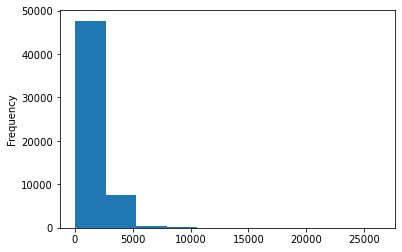

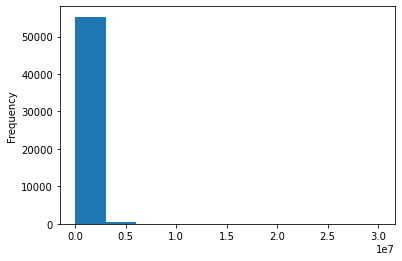

<AxesSubplot:ylabel='Frequency'>

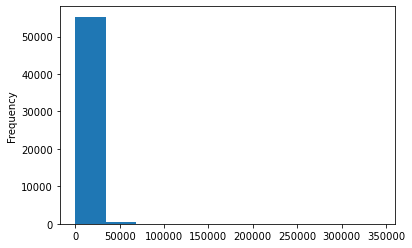

In [57]:
prop_vals_ex.calc_fin_sqft.plot.hist()
plt.show()
prop_vals_ex.tax_val.plot.hist()
plt.show()
prop_vals_ex.tax_amt.plot.hist()

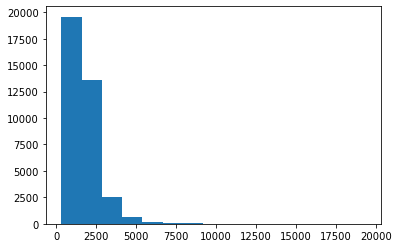

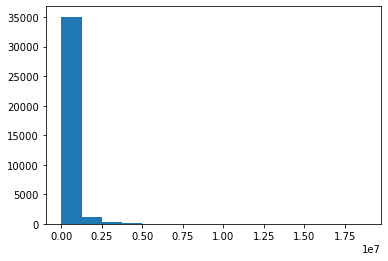

(array([3.5069e+04, 1.2280e+03, 2.4800e+02, 7.4000e+01, 3.0000e+01,
        1.3000e+01, 5.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.08930000e+02, 1.50814127e+04, 3.00538953e+04, 4.50263780e+04,
        5.99988607e+04, 7.49713433e+04, 8.99438260e+04, 1.04916309e+05,
        1.19888791e+05, 1.34861274e+05, 1.49833757e+05, 1.64806239e+05,
        1.79778722e+05, 1.94751205e+05, 2.09723687e+05, 2.24696170e+05]),
 <BarContainer object of 15 artists>)

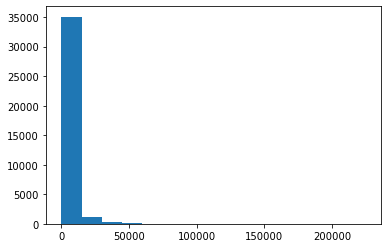

In [58]:
plt.hist(la_county_clean.calc_fin_sqft,bins= 15)
plt.show()
plt.hist(la_county_clean.tax_val, bins= 15)
plt.show()
plt.hist(la_county_clean.tax_amt, bins=15)

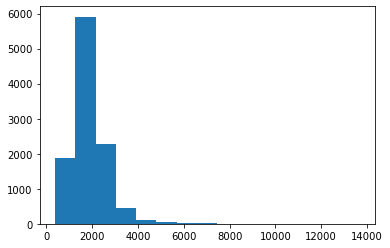

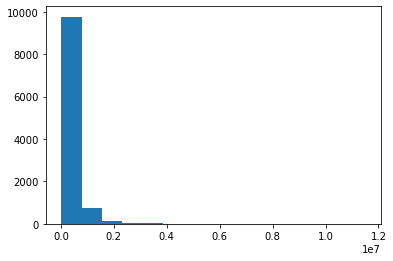

(array([9.564e+03, 9.140e+02, 1.260e+02, 4.100e+01, 1.600e+01, 9.000e+00,
        7.000e+00, 5.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00]),
 array([2.02400000e+01, 8.09630800e+03, 1.61723760e+04, 2.42484440e+04,
        3.23245120e+04, 4.04005800e+04, 4.84766480e+04, 5.65527160e+04,
        6.46287840e+04, 7.27048520e+04, 8.07809200e+04, 8.88569880e+04,
        9.69330560e+04, 1.05009124e+05, 1.13085192e+05, 1.21161260e+05]),
 <BarContainer object of 15 artists>)

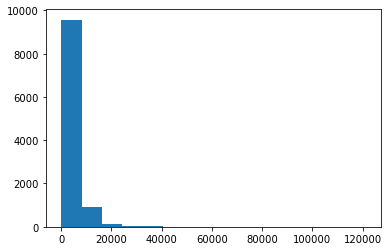

In [59]:
plt.hist(orange_county_clean.calc_fin_sqft,bins= 15)
plt.show()
plt.hist(orange_county_clean.tax_val, bins= 15)
plt.show()
plt.hist(orange_county_clean.tax_amt, bins=15)

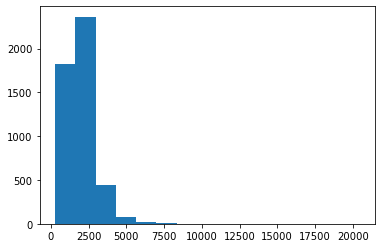

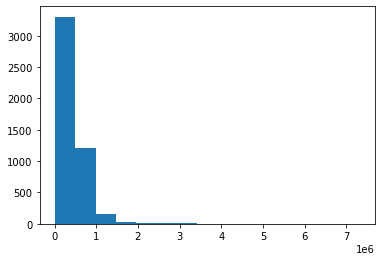

(array([3.028e+03, 1.439e+03, 1.910e+02, 3.500e+01, 1.500e+01, 1.000e+01,
        6.000e+00, 6.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.9180000e+01, 5.1970240e+03, 1.0344868e+04, 1.5492712e+04,
        2.0640556e+04, 2.5788400e+04, 3.0936244e+04, 3.6084088e+04,
        4.1231932e+04, 4.6379776e+04, 5.1527620e+04, 5.6675464e+04,
        6.1823308e+04, 6.6971152e+04, 7.2118996e+04, 7.7266840e+04]),
 <BarContainer object of 15 artists>)

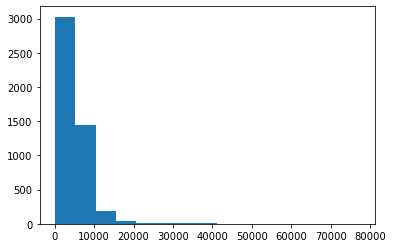

In [60]:
plt.hist(ventura_county_clean.calc_fin_sqft,bins= 15)
plt.show()
plt.hist(ventura_county_clean.tax_val, bins= 15)
plt.show()
plt.hist(ventura_county_clean.tax_amt, bins=15)

### Split data

In [61]:
# Get train, validate, and test splits of clean df
pvx_train, pvx_validate, pvx_test = ev.get_splits(prop_vals_ex)

print(pvx_train.shape, pvx_validate.shape, pvx_test.shape)

(31211, 7) (13377, 7) (11147, 7)


In [121]:
#Isolate target variable
X_pvx_tr = pvx_train.drop(columns= ['tax_val', 'tax_amt'])
y_pvx_tr = pvx_train[['tax_val']]

X_pvx_val = pvx_validate.drop(columns= ['tax_val', 'tax_amt'])
y_pvx_val = pvx_validate[['tax_val']]

X_pvx_test = pvx_test.drop(columns= ['tax_val', 'tax_amt'])
y_pvx_test = pvx_test[['tax_val']]


X_pvx_tr.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31211 entries, 8000 to 20721
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           31211 non-null  float64
 1   baths          31211 non-null  float64
 2   calc_fin_sqft  31211 non-null  float64
 3   yr_built       31211 non-null  float64
 4   fips           31211 non-null  float64
dtypes: float64(5)
memory usage: 2.4 MB


### Split county-specific subsets

In [63]:
la_train, la_validate, la_test = ev.get_splits(la_county_clean)

print(la_train.shape, la_validate.shape, la_test.shape)

(20538, 13) (8802, 13) (7335, 13)


In [64]:
orange_train, orange_val, orange_test = ev.get_splits(orange_county_clean)

print(orange_train.shape, orange_val.shape, orange_test.shape)

(5989, 15) (2567, 15) (2139, 15)


In [65]:
vent_train, vent_val, vent_test = ev.get_splits(ventura_county_clean)

print(vent_train.shape, vent_val.shape, vent_test.shape)

(2650, 14) (1136, 14) (947, 14)


In [ ]:


la_train = la_train.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
la_validate = la_validate.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
la_test = la_test.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])

orange_train = orange_train.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
orange_val = orange_val.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
orange_test = orange_test.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])

vent_train = vent_train.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
vent_val = vent_val.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])
vent_test = vent_test.drop(columns= ['structure_tax_val', 'land_tax_val', 'tax_amt'])




In [124]:
la_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20538 entries, 20977 to 45951
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           20538 non-null  int64  
 1   baths          20538 non-null  int64  
 2   pool           20538 non-null  uint8  
 3   condition      20538 non-null  int64  
 4   calc_fin_sqft  20538 non-null  float64
 5   lot_sqft       20538 non-null  float64
 6   tax_val        20538 non-null  float64
 7   yr_built       20538 non-null  int64  
 8   county_code    20538 non-null  int64  
 9   log_err        20538 non-null  float64
dtypes: float64(4), int64(5), uint8(1)
memory usage: 1.6 MB


### Isolate target variable on county subsets

In [125]:
from prep import isolate_lm_target

X_la_train, y_la_train, X_la_validate, y_la_validate, X_la_test, y_la_test = isolate_lm_target(la_train, la_validate, la_test, 'tax_val')

X_la_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20538 entries, 20977 to 45951
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           20538 non-null  int64  
 1   baths          20538 non-null  int64  
 2   pool           20538 non-null  uint8  
 3   condition      20538 non-null  int64  
 4   calc_fin_sqft  20538 non-null  float64
 5   lot_sqft       20538 non-null  float64
 6   yr_built       20538 non-null  int64  
 7   county_code    20538 non-null  int64  
 8   log_err        20538 non-null  float64
dtypes: float64(3), int64(5), uint8(1)
memory usage: 1.4 MB


In [126]:
X_orange_train, y_orange_train, X_orange_val, y_orange_val, X_orange_test, y_orange_test = isolate_lm_target(orange_train, orange_val, orange_test, 'tax_val')

X_orange_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5989 entries, 9854 to 20826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           5989 non-null   int64  
 1   baths          5989 non-null   int64  
 2   total_rooms    5989 non-null   int64  
 3   stories        5989 non-null   int64  
 4   fireplace      5989 non-null   uint8  
 5   pools          5989 non-null   uint8  
 6   calc_fin_sqft  5989 non-null   float64
 7   lot_sqft       5989 non-null   float64
 8   yr_built       5989 non-null   int64  
 9   county_code    5989 non-null   int64  
 10  log_err        5989 non-null   float64
dtypes: float64(3), int64(6), uint8(2)
memory usage: 479.6 KB


In [127]:
X_vent_train, y_vent_train, X_vent_val, y_vent_val, X_vent_test, y_vent_test = isolate_lm_target(vent_train, vent_val, vent_test, 'tax_val')

X_vent_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 21872 to 672
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           2650 non-null   int64  
 1   baths          2650 non-null   int64  
 2   total_rooms    2650 non-null   int64  
 3   stories        2650 non-null   int64  
 4   pool           2650 non-null   uint8  
 5   calc_fin_sqft  2650 non-null   float64
 6   lot_sqft       2650 non-null   float64
 7   yr_built       2650 non-null   int64  
 8   county_code    2650 non-null   int64  
 9   log_err        2650 non-null   float64
dtypes: float64(3), int64(6), uint8(1)
memory usage: 209.6 KB


### Analysis on the train splits

In [129]:

pvx_train = pvx_train.drop(columns= ['tax_amt'])
pvx_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31211 entries, 8000 to 20721
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           31211 non-null  float64
 1   baths          31211 non-null  float64
 2   calc_fin_sqft  31211 non-null  float64
 3   tax_val        31211 non-null  float64
 4   yr_built       31211 non-null  float64
 5   fips           31211 non-null  float64
dtypes: float64(6)
memory usage: 2.7 MB


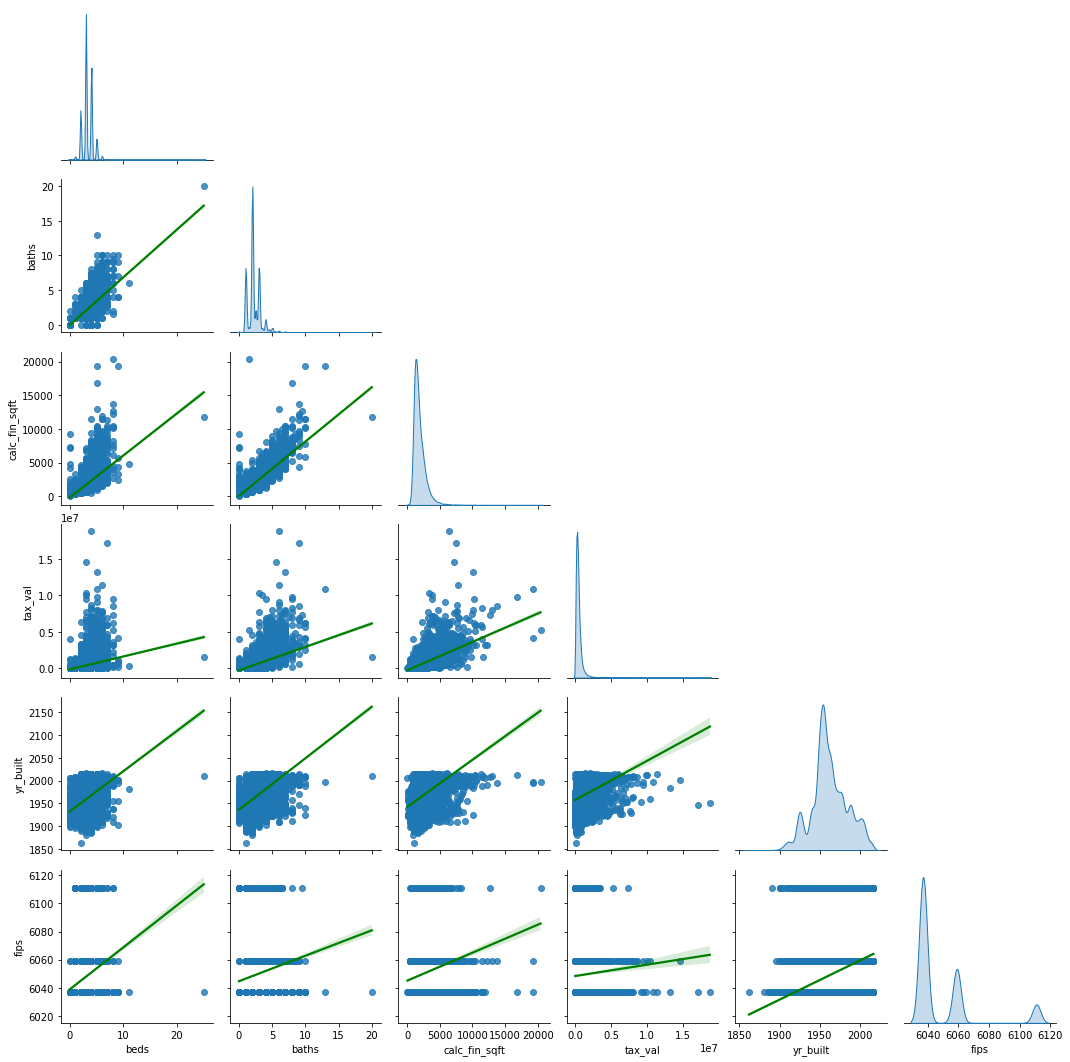

In [130]:
exp.plot_variable_pairs(pvx_train)

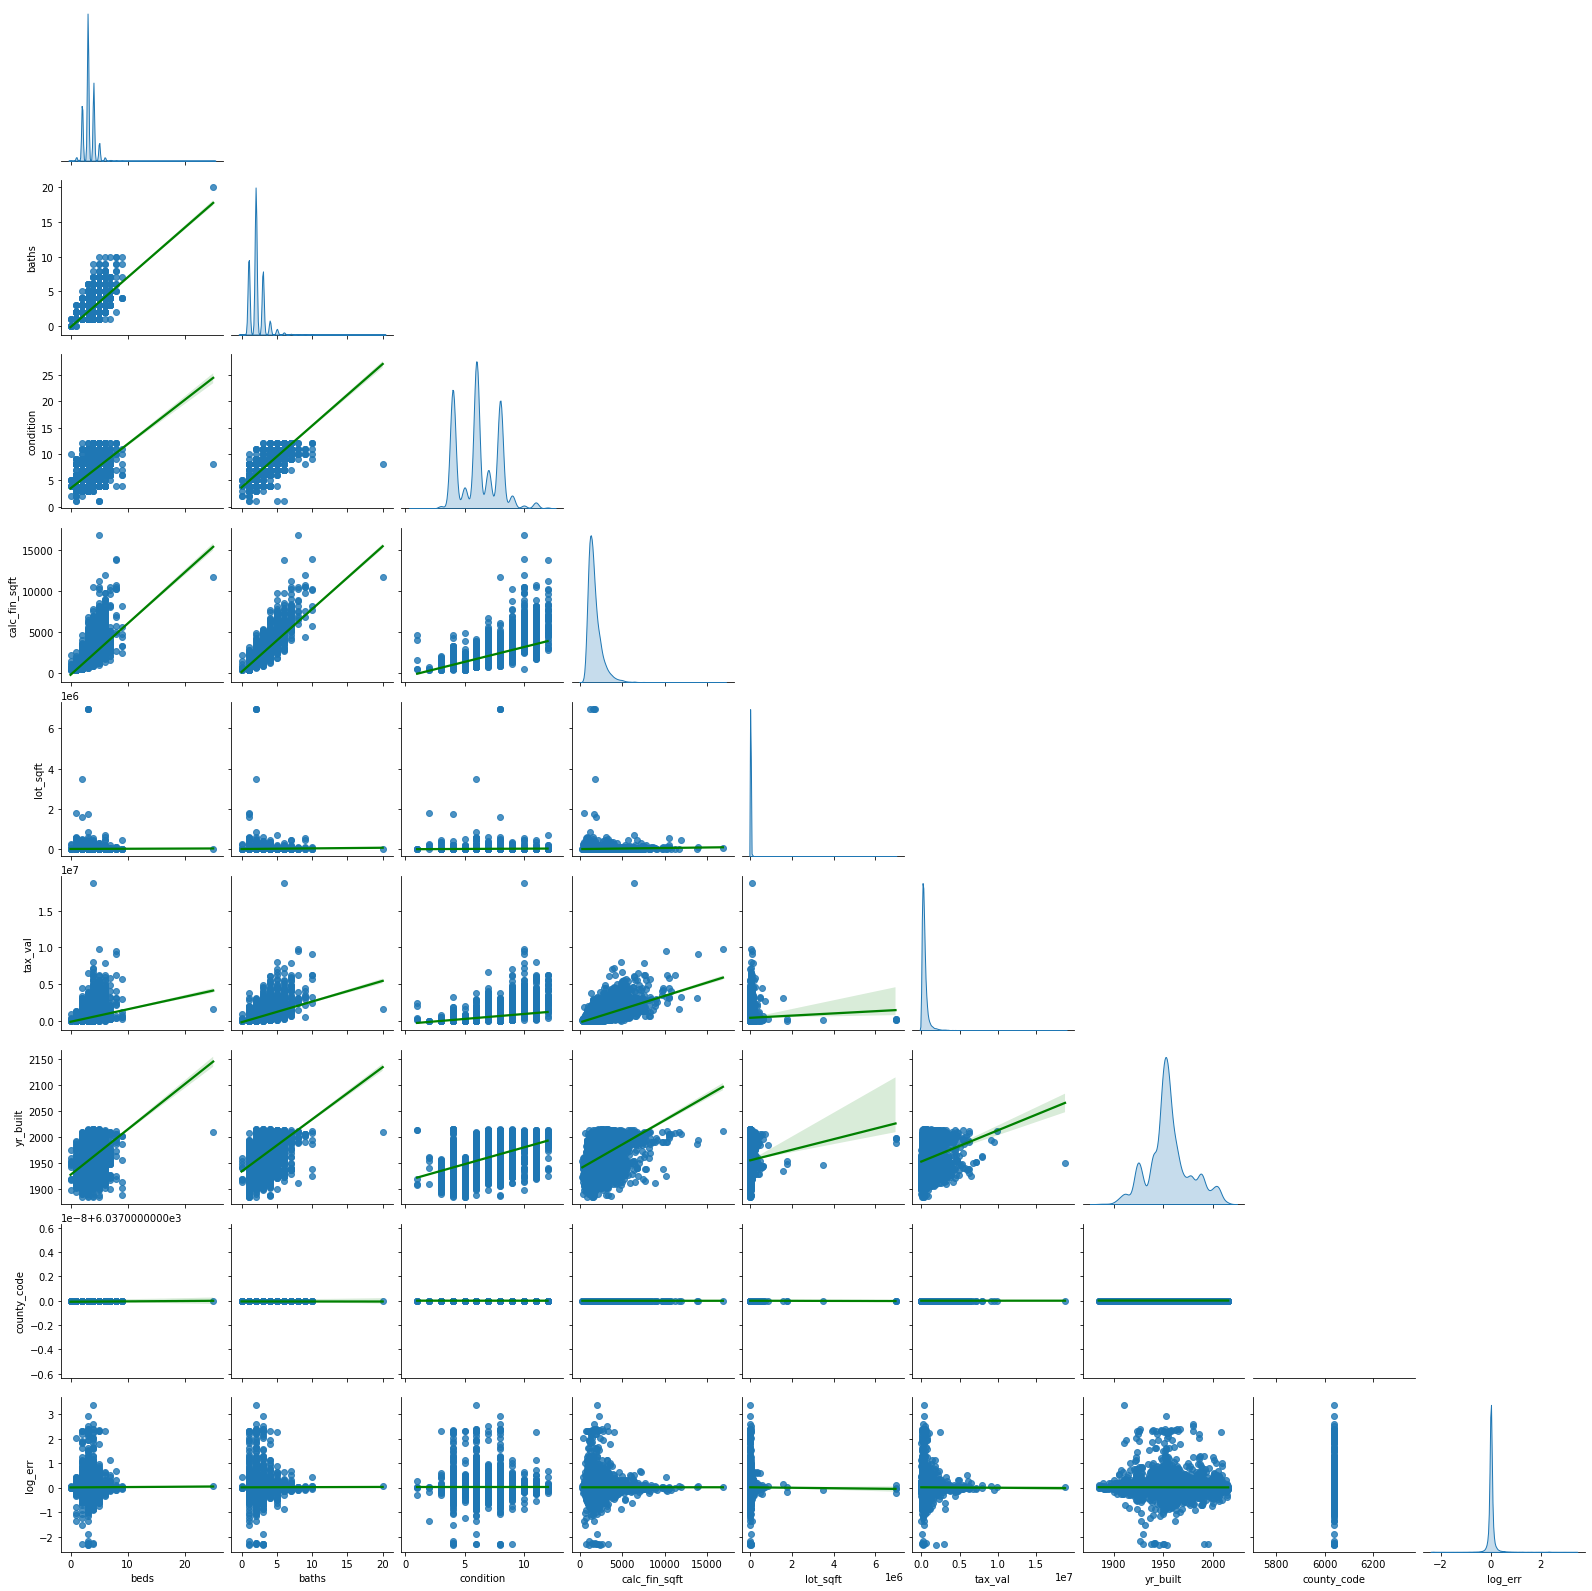

In [131]:
exp.plot_variable_pairs(la_train)

In [132]:
la_train.columns

Index(['beds', 'baths', 'pool', 'condition', 'calc_fin_sqft', 'lot_sqft',
       'tax_val', 'yr_built', 'county_code', 'log_err'],
      dtype='object')

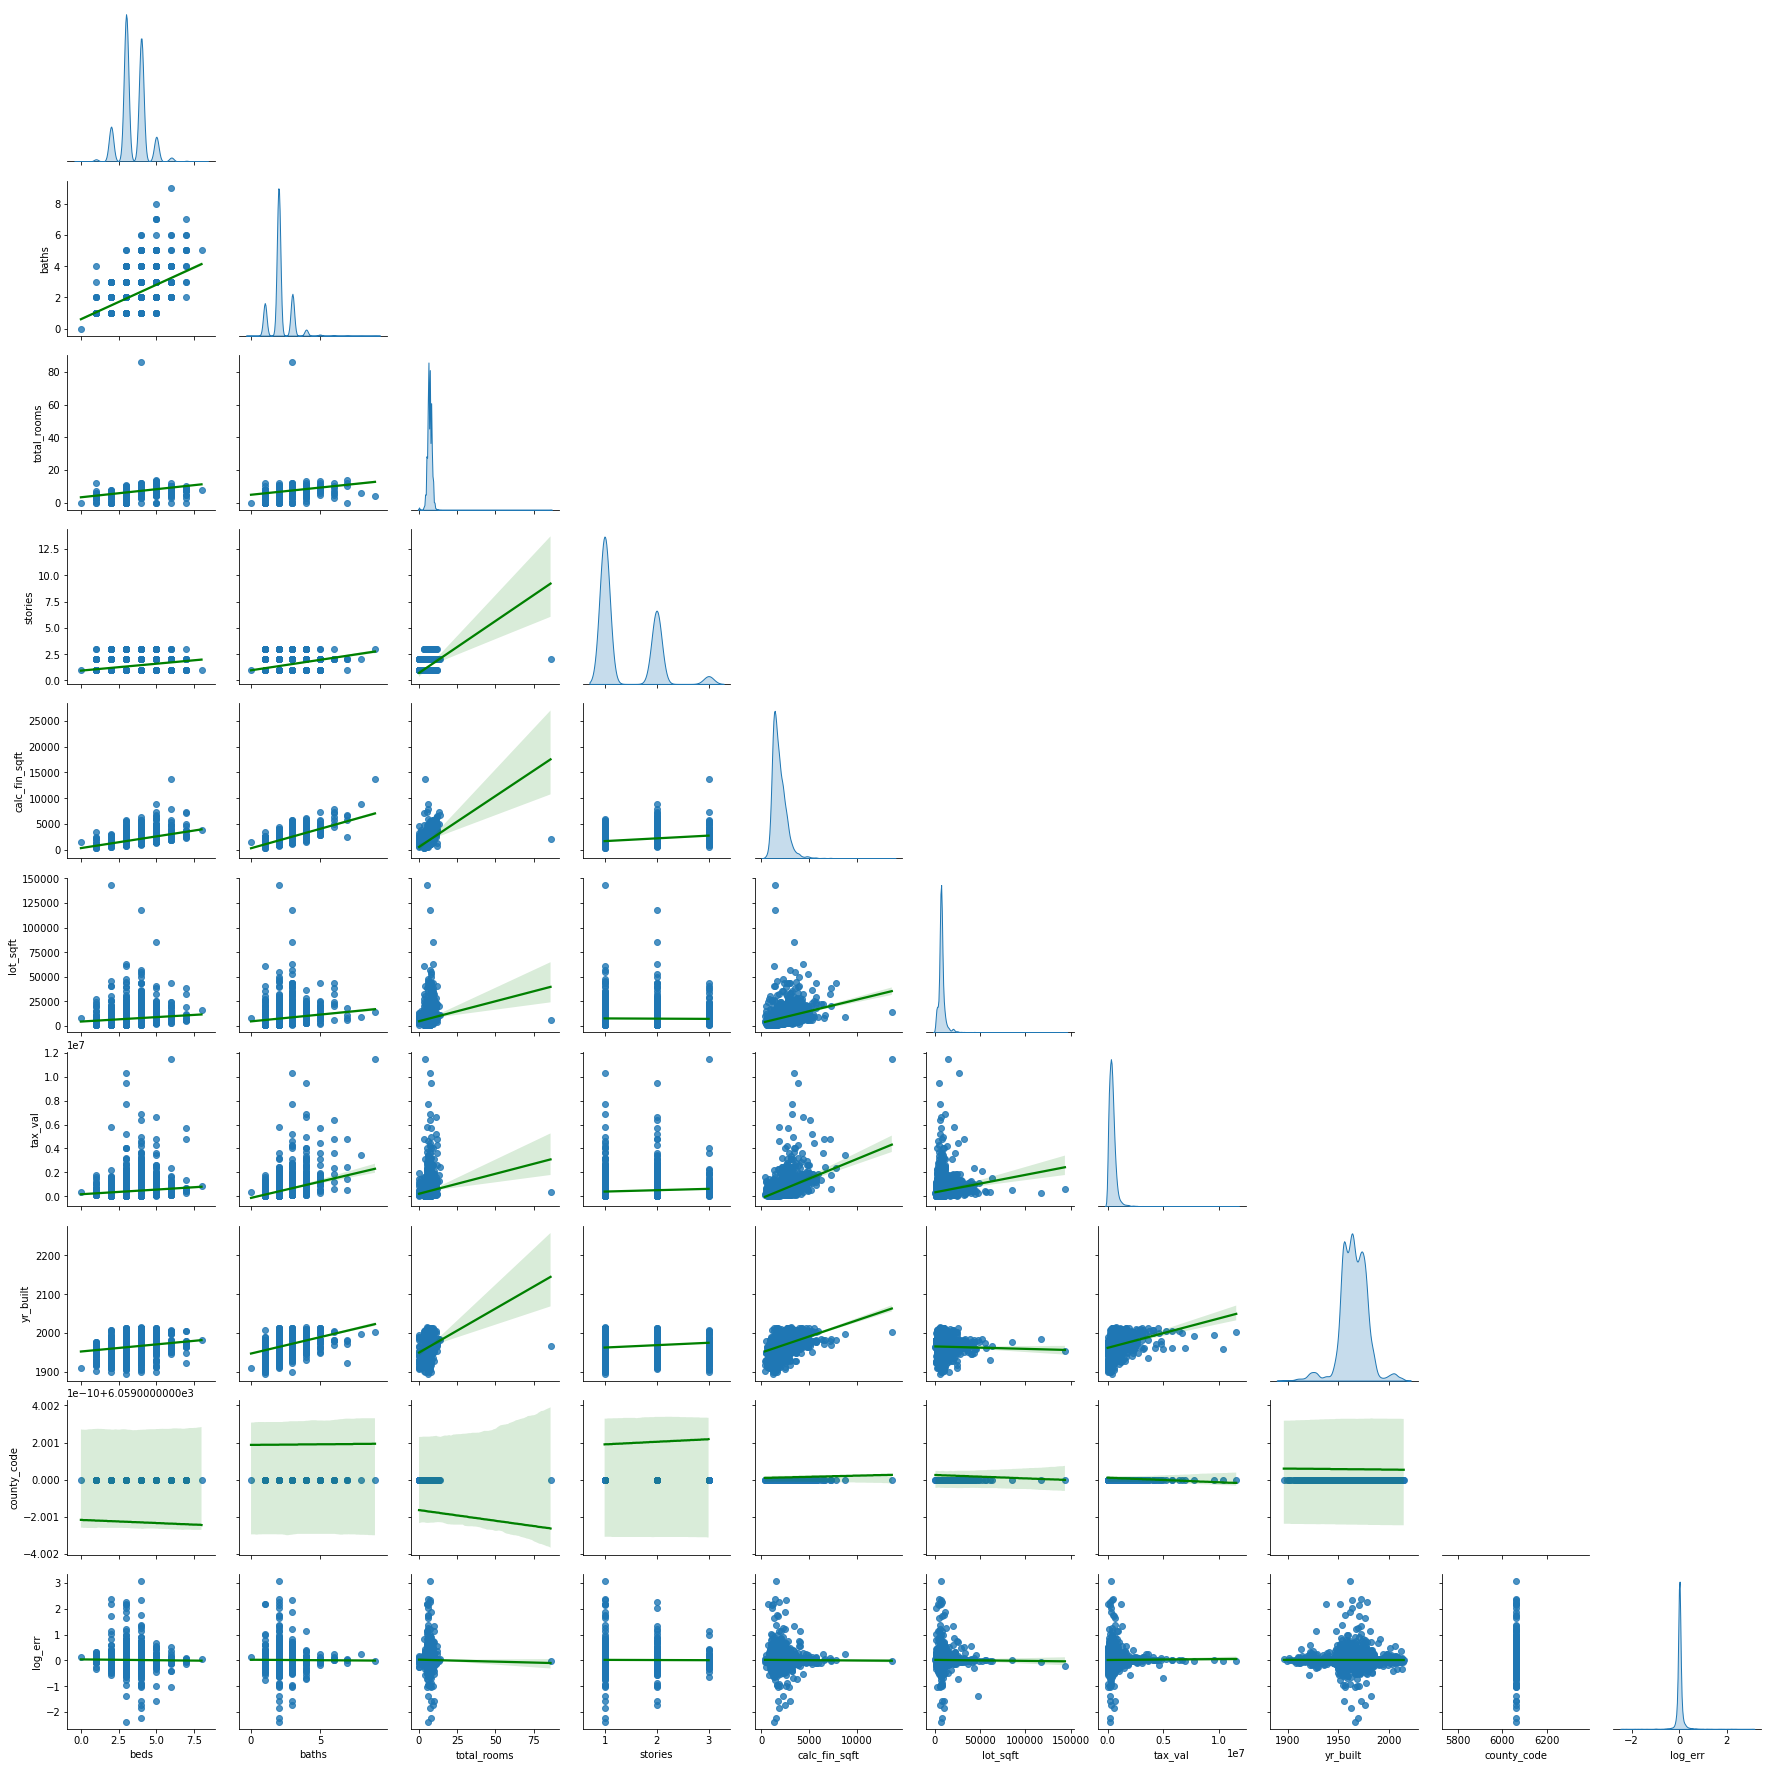

In [133]:
exp.plot_variable_pairs(orange_train)

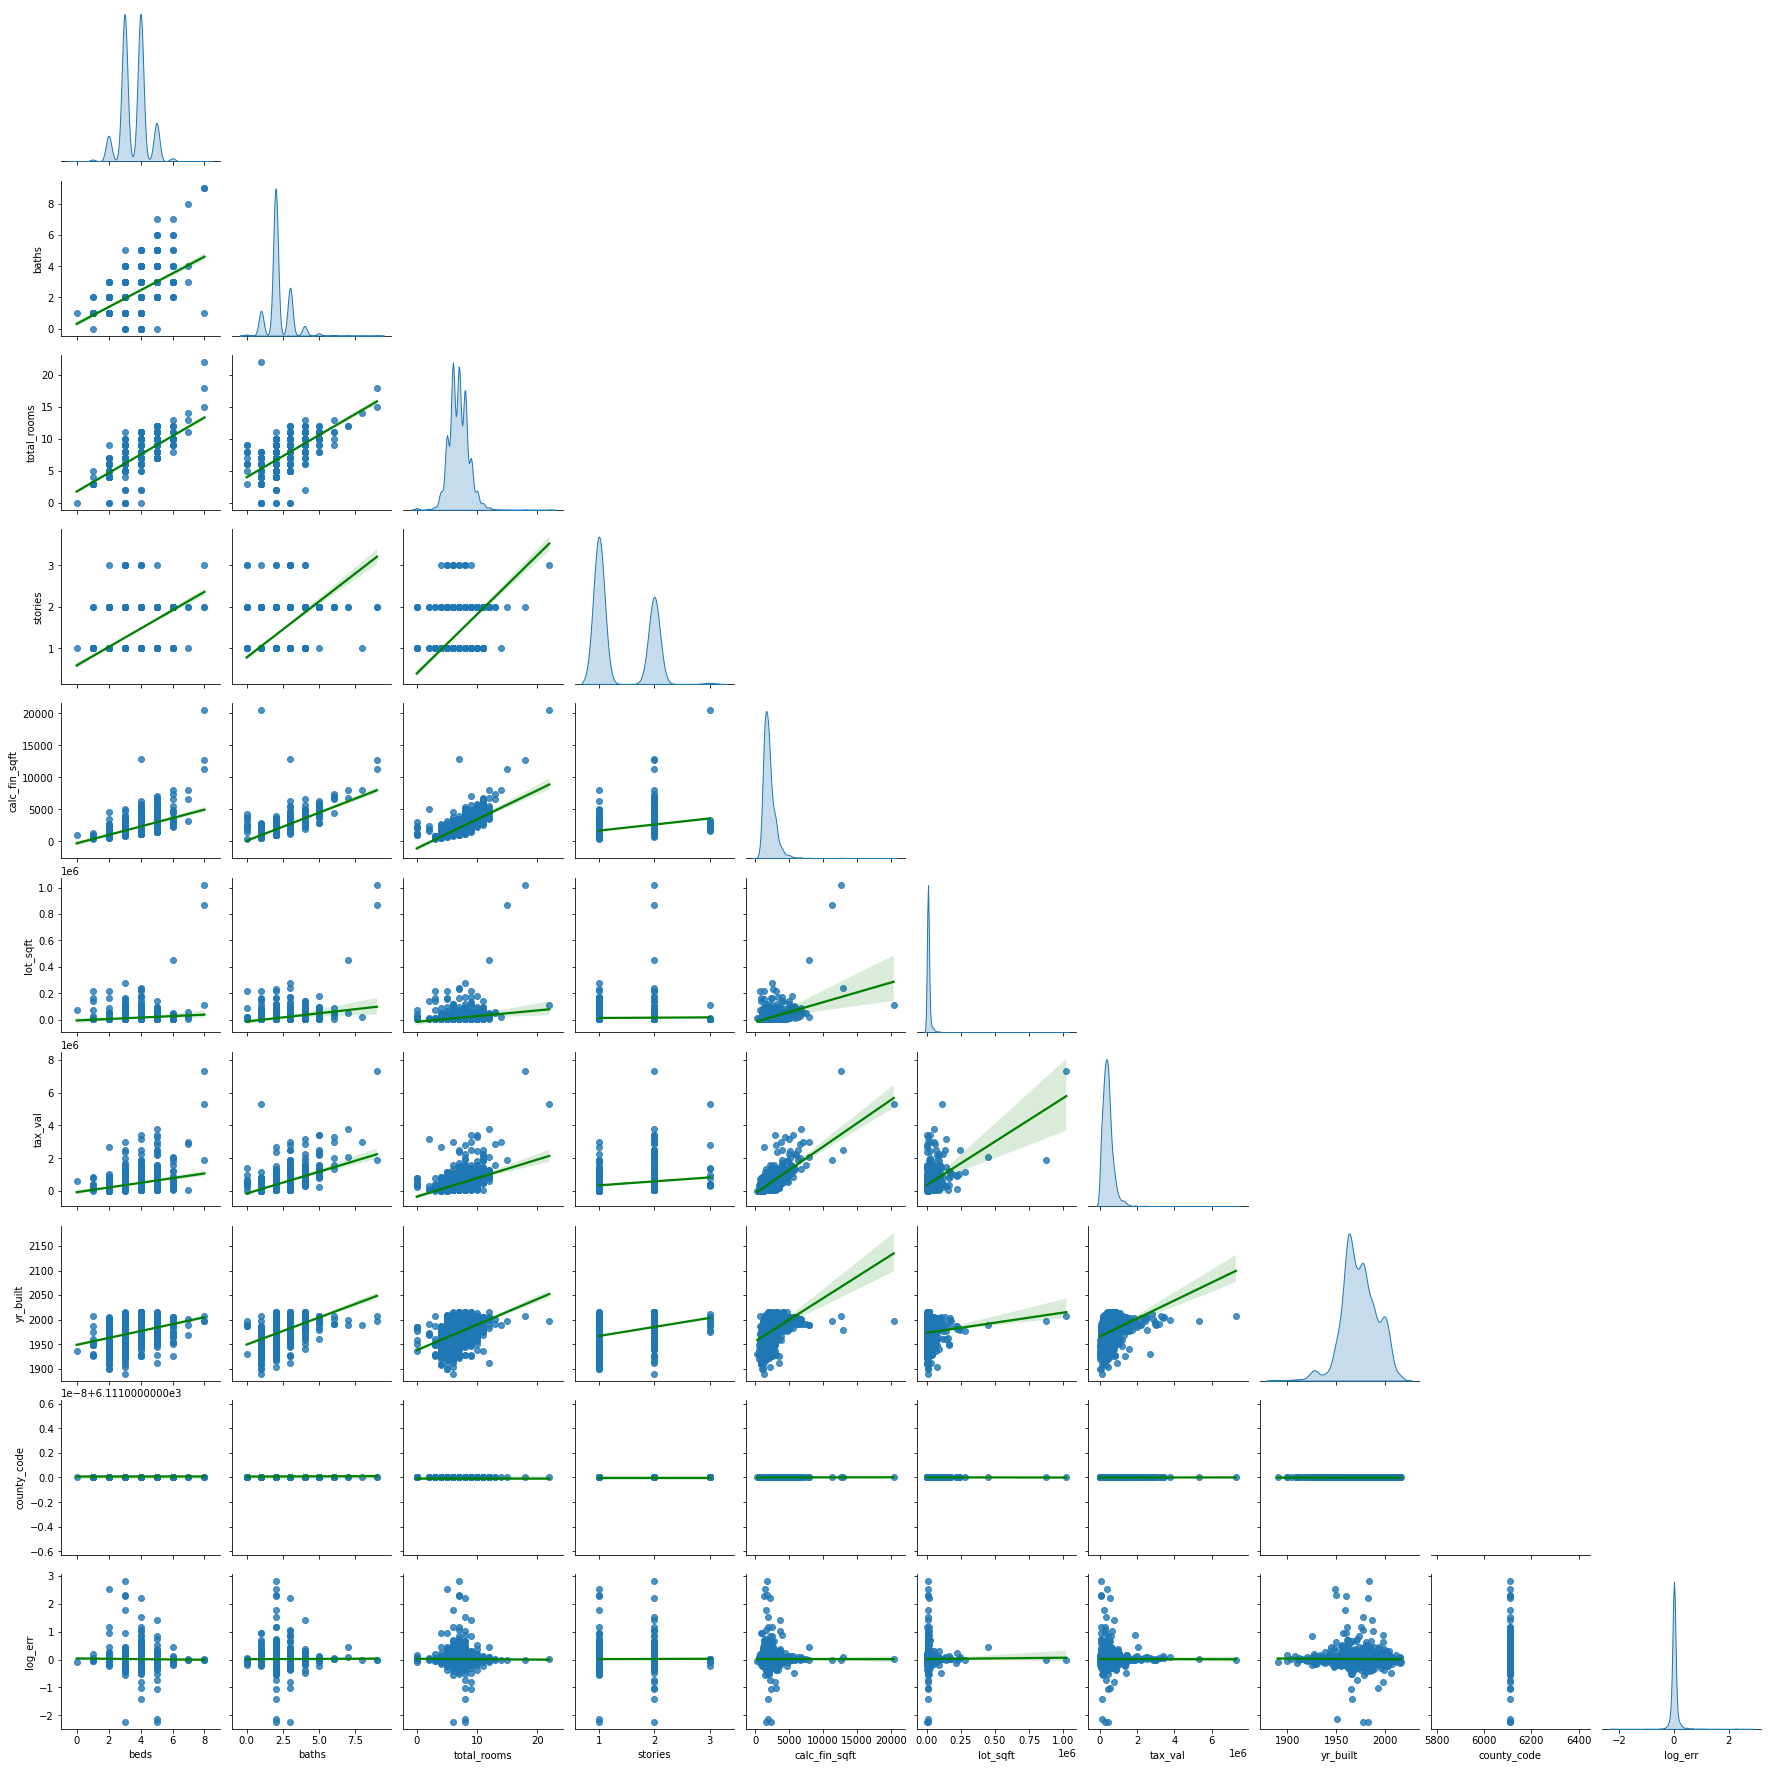

In [134]:
exp.plot_variable_pairs(vent_train)

### Takeaways: Calculated finished square feet appears to be the strongest driver of tax assessed value. Tax amount is, of course, derived from the tax assessed value, and probably should not be included as a feature in a model that is supposed to predict tax assessed value.

In [147]:
pvx_train.columns

Index(['beds', 'baths', 'calc_fin_sqft', 'tax_val', 'yr_built', 'fips'], dtype='object')

<AxesSubplot:xlabel='calc_fin_sqft', ylabel='tax_val'>

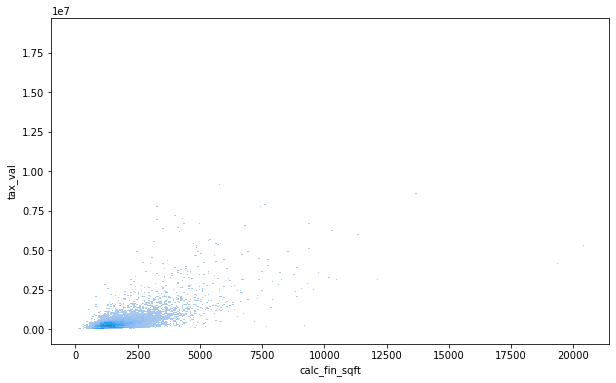

In [153]:
plt.figure(figsize=(10,6))

sns.histplot(data=pvx_train, x='calc_fin_sqft', y='tax_val')

<AxesSubplot:xlabel='beds', ylabel='tax_val'>

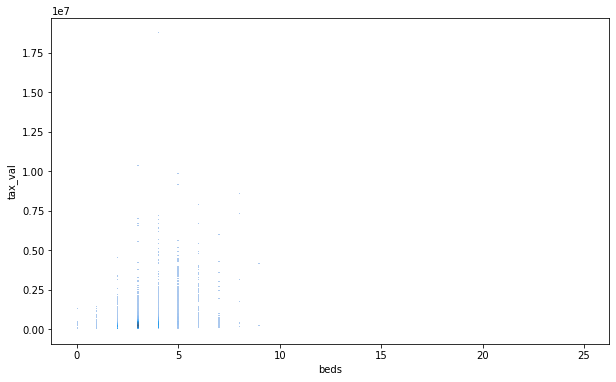

In [152]:
plt.figure(figsize=(10,6))
sns.histplot(data=pvx_train, x='beds', y='tax_val')

### Preliminary baseline and residual calculations

In [154]:
y_pvx_tr[['pvx_baseline']] = y_pvx_tr.mean()
y_la_train[['la_baseline']] = y_la_train.mean()
y_orange_train[['orange_baseline']] = y_orange_train.mean()
y_vent_train[['vent_baseline']] = y_vent_train.mean()

y_pvx_tr.head()

,tax_val,pvx_baseline
8000,71375.0,457246.169203
16213,255631.0,457246.169203
50951,309264.0,457246.169203
52150,223048.0,457246.169203
21981,326293.0,457246.169203


<AxesSubplot:xlabel='tax_val', ylabel='pvx_baseline'>

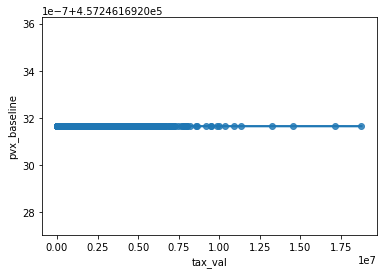

In [92]:
sns.regplot(data=y_pvx_tr, x='tax_val', y='pvx_baseline')

In [155]:
pvx_ols = LinearRegression().fit(X_pvx_tr, y_pvx_tr.tax_val)
y_pvx_tr['yhat'] = pvx_ols.predict(X_pvx_tr)

y_pvx_tr.head()

,tax_val,pvx_baseline,yhat
8000,71375.0,457246.169203,249218.401600
16213,255631.0,457246.169203,274027.596188
50951,309264.0,457246.169203,264151.629203
52150,223048.0,457246.169203,348959.294764
21981,326293.0,457246.169203,385315.848633


In [156]:
y_pvx_tr['residual'] = y_pvx_tr.yhat - y_pvx_tr.tax_val
y_pvx_tr['residual_baseline'] = y_pvx_tr.pvx_baseline - y_pvx_tr.tax_val
y_pvx_tr['residual^2'] = y_pvx_tr.residual ** 2
y_pvx_tr['residual_baseline^2'] = y_pvx_tr.residual_baseline ** 2



y_pvx_tr.head()

,tax_val,pvx_baseline,yhat,residual,residual_baseline,residual^2,residual_baseline^2
8000,71375.0,457246.169203,249218.401600,177843.401600,385871.169203,3.162828e+10,1.488966e+11
16213,255631.0,457246.169203,274027.596188,18396.596188,201615.169203,3.384348e+08,4.064868e+10
50951,309264.0,457246.169203,264151.629203,-45112.370797,147982.169203,2.035126e+09,2.189872e+10
52150,223048.0,457246.169203,348959.294764,125911.294764,234198.169203,1.585365e+10,5.484878e+10
21981,326293.0,457246.169203,385315.848633,59022.848633,130953.169203,3.483697e+09,1.714873e+10


In [157]:
pvx_mse = mean_squared_error(y_pvx_tr.tax_val, y_pvx_tr.yhat) 

pvx_mse ** 0.5

431892.3281371215

In [158]:
pvx_bl_err = mean_squared_error(y_pvx_tr.tax_val, y_pvx_tr.pvx_baseline) 

pvx_bl_err ** 0.5

580505.712158114

### Unscaled, basic model outperforms baseline by almost $150k

### Scaling

In [78]:
pvx_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31211 entries, 8000 to 20721
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           31211 non-null  float64
 1   baths          31211 non-null  float64
 2   calc_fin_sqft  31211 non-null  float64
 3   tax_val        31211 non-null  float64
 4   yr_built       31211 non-null  float64
 5   tax_amt        31211 non-null  float64
 6   fips           31211 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB


In [159]:
cols_to_scale = ['beds', 'baths', 'calc_fin_sqft', 'tax_val']

pvx_train_scaled = pvx_train.copy()
pvx_validate_scaled = pvx_validate.copy()
pvx_test_scaled = pvx_test.copy()

mmscaler = MinMaxScaler()

mmscaler.fit(pvx_train[cols_to_scale])

pvx_train_scaled[cols_to_scale] = mmscaler.transform(pvx_train[cols_to_scale])
pvx_validate_scaled[cols_to_scale] = mmscaler.transform(pvx_validate[cols_to_scale])
pvx_test_scaled[cols_to_scale] = mmscaler.transform(pvx_test[cols_to_scale])


pvx_train_scaled

,beds,baths,calc_fin_sqft,tax_val,yr_built,fips
8000,0.12,0.100,0.060129,0.003719,1955.0,6059.0
16213,0.12,0.100,0.065577,0.013530,1964.0,6037.0
50951,0.12,0.100,0.062239,0.016386,1956.0,6059.0
52150,0.16,0.100,0.089334,0.011795,1963.0,6059.0
21981,0.20,0.150,0.097678,0.017293,1966.0,6111.0
...,...,...,...,...,...,...
33899,0.12,0.050,0.066313,0.011053,1950.0,6037.0
33535,0.12,0.100,0.063466,0.032026,1948.0,6037.0
43370,0.12,0.100,0.060521,0.004071,1970.0,6111.0
17997,0.12,0.100,0.084965,0.004938,1952.0,6037.0


In [160]:
X_pvx_train_scaled, y_pvx_train_scaled, X_pvx_validate_scaled, y_pvx_validate_scaled, X_pvx_test_scaled, y_pvx_test_scaled = isolate_lm_target(pvx_train_scaled, pvx_validate_scaled, pvx_test_scaled, 'tax_val')

X_pvx_train_scaled.head()

,beds,baths,calc_fin_sqft,yr_built,fips
8000,0.12,0.10,0.060129,1955.0,6059.0
16213,0.12,0.10,0.065577,1964.0,6037.0
50951,0.12,0.10,0.062239,1956.0,6059.0
52150,0.16,0.10,0.089334,1963.0,6059.0
21981,0.20,0.15,0.097678,1966.0,6111.0


In [161]:
pvx_ols_scaled = LinearRegression().fit(X_pvx_train_scaled, y_pvx_tr.tax_val)

y_pvx_tr['yhat_scaled'] = pvx_ols_scaled.predict(X_pvx_train_scaled)
y_pvx_tr.head()

,tax_val,pvx_baseline,yhat,residual,residual_baseline,residual^2,residual_baseline^2,yhat_scaled
8000,71375.0,457246.169203,249218.401600,177843.401600,385871.169203,3.162828e+10,1.488966e+11,249218.401600
16213,255631.0,457246.169203,274027.596188,18396.596188,201615.169203,3.384348e+08,4.064868e+10,274027.596188
50951,309264.0,457246.169203,264151.629203,-45112.370797,147982.169203,2.035126e+09,2.189872e+10,264151.629203
52150,223048.0,457246.169203,348959.294764,125911.294764,234198.169203,1.585365e+10,5.484878e+10,348959.294764
21981,326293.0,457246.169203,385315.848633,59022.848633,130953.169203,3.483697e+09,1.714873e+10,385315.848633


In [162]:
print((y_pvx_tr.yhat == y_pvx_tr.yhat_scaled).sum())

y_pvx_tr['scaled_residual'] = y_pvx_tr.yhat_scaled - y_pvx_tr.tax_val

y_pvx_tr.head()




805


,tax_val,pvx_baseline,yhat,residual,residual_baseline,residual^2,residual_baseline^2,yhat_scaled,scaled_residual
8000,71375.0,457246.169203,249218.401600,177843.401600,385871.169203,3.162828e+10,1.488966e+11,249218.401600,177843.401600
16213,255631.0,457246.169203,274027.596188,18396.596188,201615.169203,3.384348e+08,4.064868e+10,274027.596188,18396.596188
50951,309264.0,457246.169203,264151.629203,-45112.370797,147982.169203,2.035126e+09,2.189872e+10,264151.629203,-45112.370797
52150,223048.0,457246.169203,348959.294764,125911.294764,234198.169203,1.585365e+10,5.484878e+10,348959.294764,125911.294764
21981,326293.0,457246.169203,385315.848633,59022.848633,130953.169203,3.483697e+09,1.714873e+10,385315.848633,59022.848633


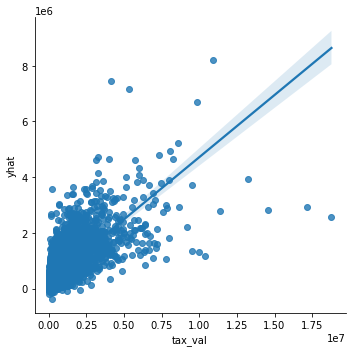

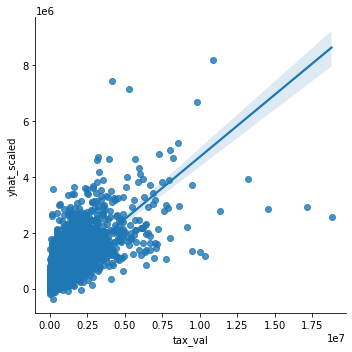

In [163]:
sns.lmplot(data=y_pvx_tr, x='tax_val', y='yhat')
plt.show()
sns.lmplot(data=y_pvx_tr, x='tax_val', y='yhat_scaled')

In [164]:
print(mean_squared_error(y_pvx_tr.tax_val, y_pvx_tr.yhat) ** 0.5, mean_squared_error(y_pvx_tr.tax_val, y_pvx_tr.yhat_scaled) ** 0.5)

431892.3281371215 431892.32813712157


In [165]:
import prep

f_feature = prep.select_kbest(X_pvx_train_scaled, y_pvx_tr.tax_val, 4)

f_feature

['beds', 'baths', 'calc_fin_sqft', 'yr_built']

In [167]:
f_feature = prep.select_kbest(X_pvx_train_scaled, y_pvx_tr.tax_val, 2)

f_feature

['baths', 'calc_fin_sqft']

In [175]:
pvx_ols_kbest = LinearRegression().fit(X_pvx_train_scaled[f_feature], y_pvx_tr.tax_val)

y_pvx_tr['yhat_kbest'] = pvx_ols_kbest.predict(X_pvx_train_scaled[f_feature])

y_pvx_tr.head()

,tax_val,pvx_baseline,yhat,residual,residual_baseline,residual^2,residual_baseline^2,yhat_scaled,scaled_residual,yhat_kbest,yhat_rfe
8000,71375.0,457246.169203,249218.401600,177843.401600,385871.169203,3.162828e+10,1.488966e+11,249218.401600,177843.401600,235529.613354,224459.518261
16213,255631.0,457246.169203,274027.596188,18396.596188,201615.169203,3.384348e+08,4.064868e+10,274027.596188,18396.596188,276495.735123,274781.098484
50951,309264.0,457246.169203,264151.629203,-45112.370797,147982.169203,2.035126e+09,2.189872e+10,264151.629203,-45112.370797,251399.372238,243953.463753
52150,223048.0,457246.169203,348959.294764,125911.294764,234198.169203,1.585365e+10,5.484878e+10,348959.294764,125911.294764,455122.788602,387463.023835
21981,326293.0,457246.169203,385315.848633,59022.848633,130953.169203,3.483697e+09,1.714873e+10,385315.848633,59022.848633,541326.096998,357793.812340


In [176]:
kbest_mse = mean_squared_error(y_pvx_tr.tax_val, y_pvx_tr.yhat_kbest)

kbest_mse ** 0.5

442848.20082946046

In [170]:
X_pvx_train_scaled.columns

Index(['beds', 'baths', 'calc_fin_sqft', 'yr_built', 'fips'], dtype='object')

In [172]:
rfe_feature, rfe_ranked = prep.rfe(X_pvx_train_scaled, y_pvx_tr.tax_val, 2)

rfe_ranked

,Var,Rank
0,beds,1
1,baths,2
2,calc_fin_sqft,1
3,yr_built,3
4,fips,4


In [173]:
pvx_ols_rfe = LinearRegression().fit(X_pvx_train_scaled[rfe_feature], y_pvx_tr.tax_val)

y_pvx_tr['yhat_rfe'] = pvx_ols_rfe.predict(X_pvx_train_scaled[rfe_feature])

y_pvx_tr.head()

,tax_val,pvx_baseline,yhat,residual,residual_baseline,residual^2,residual_baseline^2,yhat_scaled,scaled_residual,yhat_kbest,yhat_rfe
8000,71375.0,457246.169203,249218.401600,177843.401600,385871.169203,3.162828e+10,1.488966e+11,249218.401600,177843.401600,235529.613354,224459.518261
16213,255631.0,457246.169203,274027.596188,18396.596188,201615.169203,3.384348e+08,4.064868e+10,274027.596188,18396.596188,276495.735123,274781.098484
50951,309264.0,457246.169203,264151.629203,-45112.370797,147982.169203,2.035126e+09,2.189872e+10,264151.629203,-45112.370797,251399.372238,243953.463753
52150,223048.0,457246.169203,348959.294764,125911.294764,234198.169203,1.585365e+10,5.484878e+10,348959.294764,125911.294764,455122.788602,387463.023835
21981,326293.0,457246.169203,385315.848633,59022.848633,130953.169203,3.483697e+09,1.714873e+10,385315.848633,59022.848633,541326.096998,357793.812340


In [174]:
rfe_rmse = mean_squared_error(y_pvx_tr.tax_val, y_pvx_tr.yhat_rfe) ** 0.5

rfe_rmse



435832.45209314197

### Takeaways: Models performed ~$150k better than baseline. Calculated finished sq ft and bedrooms were top features.

In [95]:
y_pvx_train_scaled.columns

Index(['tax_val'], dtype='object')

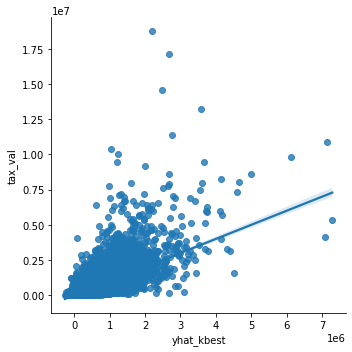

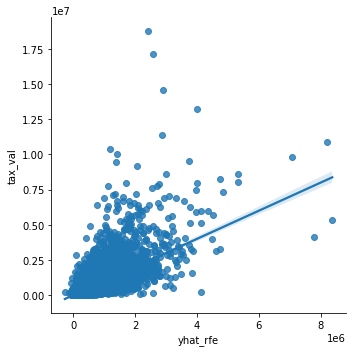

In [177]:
sns.lmplot(data= y_pvx_tr, x='yhat_kbest', y= 'tax_val')
plt.show()
sns.lmplot(data= y_pvx_tr, x='yhat_rfe', y= 'tax_val')

In [179]:
X_la_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20538 entries, 20977 to 45951
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           20538 non-null  int64  
 1   baths          20538 non-null  int64  
 2   pool           20538 non-null  uint8  
 3   condition      20538 non-null  int64  
 4   calc_fin_sqft  20538 non-null  float64
 5   lot_sqft       20538 non-null  float64
 6   yr_built       20538 non-null  int64  
 7   county_code    20538 non-null  int64  
 8   log_err        20538 non-null  float64
dtypes: float64(3), int64(5), uint8(1)
memory usage: 1.4 MB


In [180]:
cols_to_scale = ['beds', 'baths', 'condition', 'calc_fin_sqft', 'lot_sqft', 'log_err']

X_la_train_scaled = X_la_train.copy()
X_la_validate_scaled = X_la_validate.copy()
X_la_test_scaled = X_la_test.copy()

mmscaler = MinMaxScaler()

mmscaler.fit(X_la_train[cols_to_scale])

X_la_train_scaled[cols_to_scale] = mmscaler.transform(X_la_train[cols_to_scale])
X_la_validate_scaled[cols_to_scale] = mmscaler.transform(X_la_validate[cols_to_scale])
X_la_test_scaled[cols_to_scale] = mmscaler.transform(X_la_test[cols_to_scale])


X_la_train_scaled

,beds,baths,pool,condition,calc_fin_sqft,lot_sqft,yr_built,county_code,log_err
20977,0.24,0.15,1,0.545455,0.210246,0.001045,2002,6037,0.407310
37653,0.12,0.05,0,0.272727,0.043307,0.000739,1959,6037,0.430660
24143,0.08,0.05,1,0.272727,0.042340,0.000691,1939,6037,0.404239
55457,0.08,0.15,0,0.636364,0.089881,0.002624,1964,6037,0.408684
1296,0.12,0.15,1,0.636364,0.091091,0.000953,1952,6037,0.411481
...,...,...,...,...,...,...,...,...,...
39086,0.12,0.10,0,0.272727,0.044698,0.000966,1955,6037,0.416199
27429,0.16,0.05,0,0.272727,0.052985,0.000418,1966,6037,0.403353
12927,0.12,0.10,0,0.636364,0.087522,0.000727,1990,6037,0.407271
14297,0.08,0.05,0,0.454545,0.058550,0.000974,1925,6037,0.416516


In [183]:
X_latr_ols = LinearRegression().fit(X_la_train_scaled, y_la_train)

y_la_train['baseline'] = y_la_train.tax_val.mean()

y_la_train = y_la_train.drop(columns= ['baseline'])

y_la_train.head()

,tax_val,la_baseline
20977,690966.0,423457.341611
37653,401023.0,423457.341611
24143,259740.0,423457.341611
55457,476190.0,423457.341611
1296,586416.0,423457.341611


In [185]:
type(X_latr_ols.predict(X_la_train_scaled))

y_la_train['yhat_scaled'] = X_latr_ols.predict(X_la_train_scaled)

y_la_train.head()

ValueError: Wrong number of items passed 3, placement implies 1